<a href="https://colab.research.google.com/github/daniellegauthier/color-data-analysis/blob/main/module3_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import nbformat
from google.colab import _message

# Step 1: Get the current notebook as a dict
current_notebook = _message.blocking_request('get_ipynb')['ipynb']

# Step 2: Convert it to a proper NotebookNode
nb_node = nbformat.from_dict(current_notebook)

# Step 3: Remove broken widgets metadata if it exists
if 'widgets' in nb_node['metadata']:
    del nb_node['metadata']['widgets']

# Step 4: Save the cleaned notebook
cleaned_path = '/content/cleaned_notebook.ipynb'
with open(cleaned_path, 'w') as f:
    nbformat.write(nb_node, f)

print(f"✅ Cleaned notebook saved to {cleaned_path}")


✅ Cleaned notebook saved to /content/cleaned_notebook.ipynb


In [ ]:
!pip install requests pandas numpy scikit-learn matplotlib requests

Fetching color data...
Fetching sequence data...

Color Data Sample:
    color    r    g    b   matrice1 matrice  \
0    grey  170  170  170     Cover     lose   
1    pink  250    0   90  Category    place   
2    gold  250  200    0      Pull     hide   
3    nude  250  180  120  Approach     jump   
4  orange  250  110    0       Hit     drop   

                                    english-words    english-words-code  
0           respectful effective apposite precary               precary  
1             incredibily exquisite and ambitious             ambitious  
2  undepartable preflorating technocracy lotiform  technocracy lotiform  
3        felicitously deft satisfied unextenuable          unextenuable  
4                         blurry artesian awesome       blurry artesian  

Sequence Data Sample:
     ï»¿name                                           sequence
0       plot                     grey, pink, gold, nude, orange
1       knot  white, blue, green, red, black, brown, 

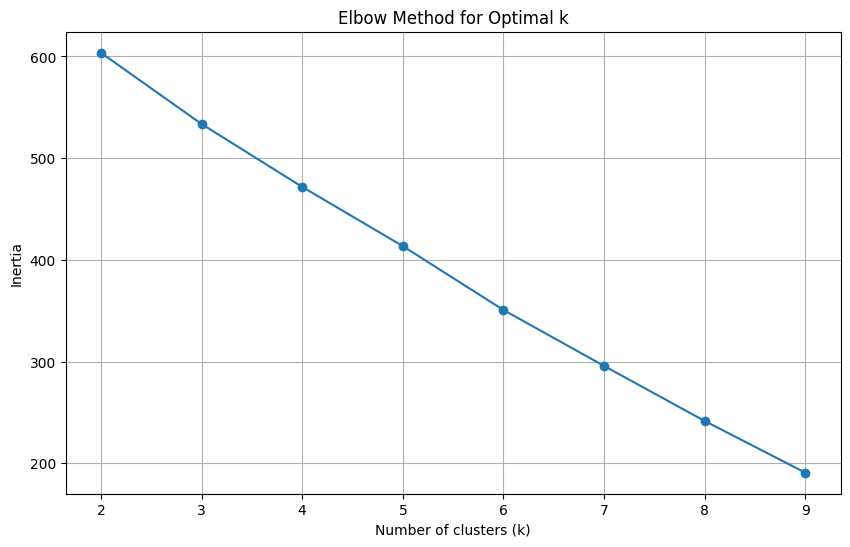

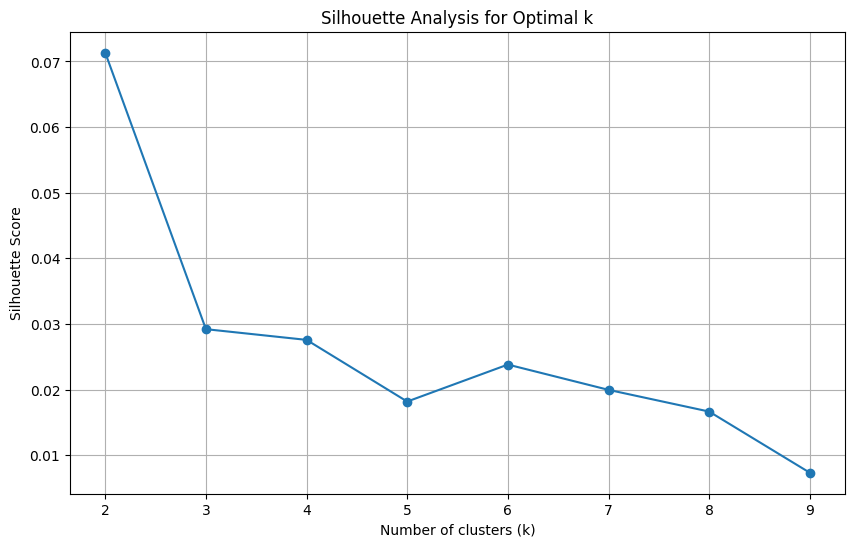

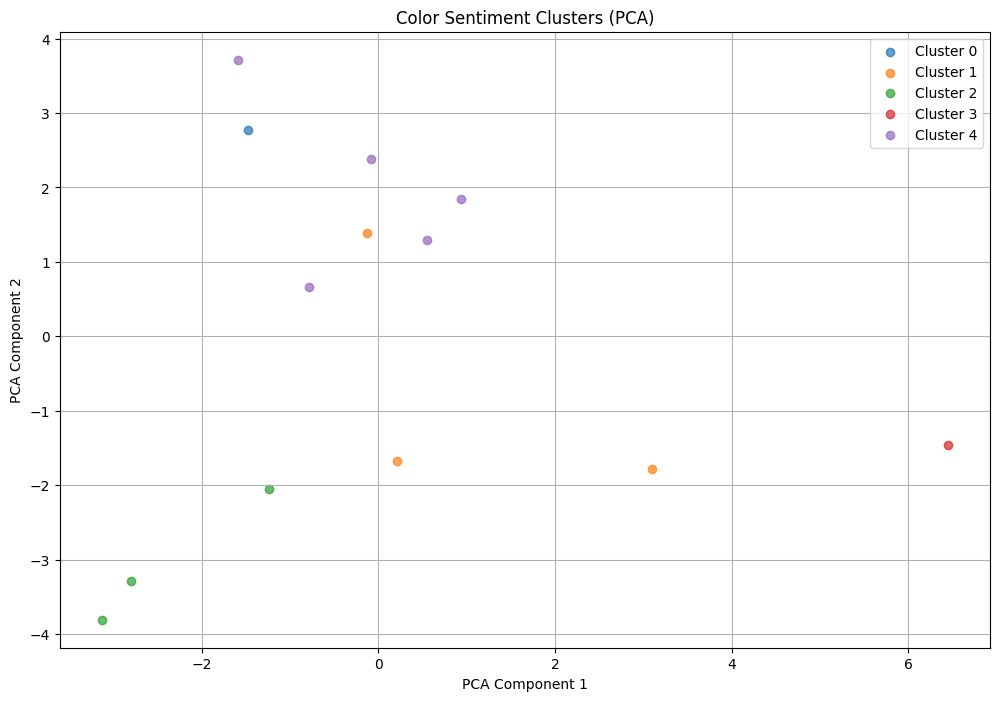

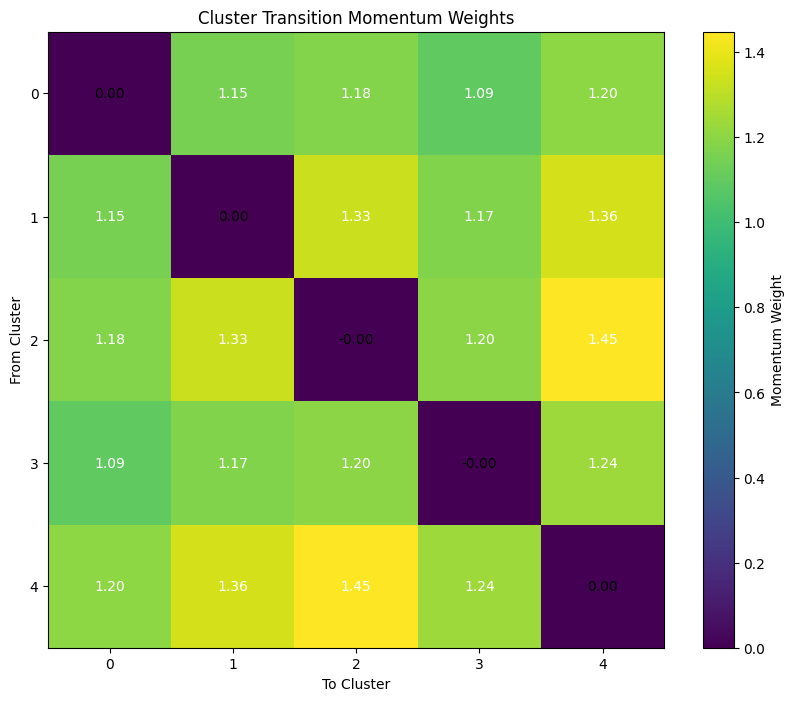

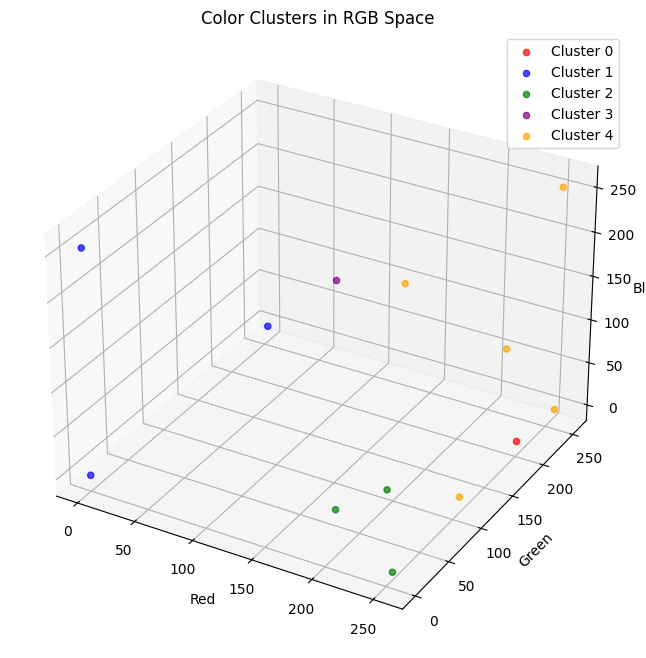

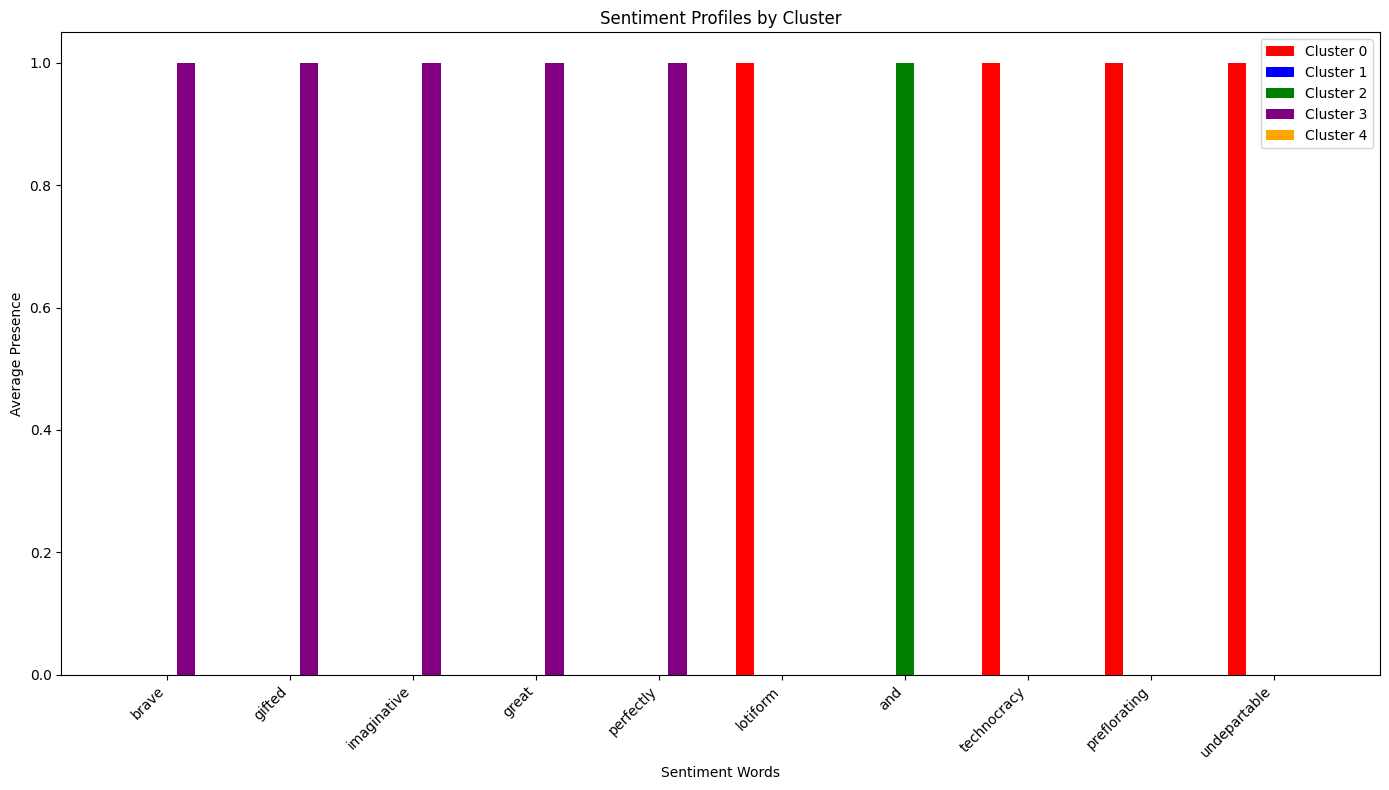

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import requests
from io import StringIO
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# URLs for the CSV files
colors_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice-qhiF8W1MZiXnmjlkL6xJasXeG1FryC.csv"
sequences_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice%20sequences-2j9pbWxr7vXA22q5VUTWXYgyaSe9dO.csv"

# Function to fetch and parse CSV data
def fetch_csv(url):
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Fetch the data
print("Fetching color data...")
colors_df = fetch_csv(colors_url)
print("Fetching sequence data...")
sequences_df = fetch_csv(sequences_url)

# Display the first few rows of each dataset
print("\nColor Data Sample:")
print(colors_df.head())
print("\nSequence Data Sample:")
print(sequences_df.head())

# Clean and prepare the color sentiment data
print("\nPreparing color sentiment data...")

# Make sure RGB values are numeric
for col in ['r', 'g', 'b']:
    colors_df[col] = pd.to_numeric(colors_df[col], errors='coerce')

# Extract sentiment features using text vectorization
# First, clean the english-words column
colors_df['clean_words'] = colors_df['english-words'].fillna('').astype(str)

# Use CountVectorizer to create binary features for sentiment words
vectorizer = CountVectorizer(binary=True, max_features=100)
sentiment_features = vectorizer.fit_transform(colors_df['clean_words'])
sentiment_df = pd.DataFrame(
    sentiment_features.toarray(),
    columns=[f'sentiment_{word}' for word in vectorizer.get_feature_names_out()],
    index=colors_df.index
)

# Combine RGB values with sentiment features
X_rgb = colors_df[['r', 'g', 'b']].fillna(0)
X = pd.concat([X_rgb, sentiment_df], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
print("Determining optimal number of clusters...")

# Calculate silhouette scores
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)

# Choose k=5 based on analysis
k = 5
print(f"\nPerforming k-means clustering with k={k}...")
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
colors_df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for cluster in range(k):
    plt.scatter(
        X_pca[colors_df['cluster'] == cluster, 0],
        X_pca[colors_df['cluster'] == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title('Color Sentiment Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)

# Analyze the clusters
print("\nCluster Analysis:")
for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_colors)} colors):")
    print(f"  Common colors: {', '.join(cluster_colors['color'].value_counts().head(5).index.tolist())}")

    # Find most common sentiment words in this cluster
    cluster_sentiments = sentiment_df.loc[cluster_colors.index].sum().sort_values(ascending=False)
    print(f"  Top sentiments: {', '.join(cluster_sentiments.head(5).index.str.replace('sentiment_', '').tolist())}")

    # Average RGB values for this cluster
    avg_rgb = cluster_colors[['r', 'g', 'b']].mean()
    print(f"  Average RGB: ({avg_rgb['r']:.1f}, {avg_rgb['g']:.1f}, {avg_rgb['b']:.1f})")

# Create a color-to-cluster mapping
color_to_cluster = dict(zip(colors_df['color'], colors_df['cluster']))

# Parse the sequences
print("\nAnalyzing color sequences...")
def parse_sequence(seq_str):
    if pd.isna(seq_str):
        return []
    return [color.strip().lower() for color in seq_str.split(',')]

sequences_df['parsed_sequence'] = sequences_df['sequence'].apply(parse_sequence)

# Calculate sequence momentum based on cluster transitions
def calculate_momentum(sequence, color_to_cluster, cluster_weights=None):
    if cluster_weights is None:
        # Default weights: transitions between different clusters have higher momentum
        cluster_weights = np.ones((k, k)) - np.eye(k)

    momentum = 0
    valid_transitions = 0

    for i in range(len(sequence) - 1):
        color1 = sequence[i]
        color2 = sequence[i + 1]

        # Skip if colors not in our dataset
        if color1 not in color_to_cluster or color2 not in color_to_cluster:
            continue

        cluster1 = color_to_cluster[color1]
        cluster2 = color_to_cluster[color2]

        # Add momentum based on cluster transition
        momentum += cluster_weights[cluster1, cluster2]
        valid_transitions += 1

    # Return average momentum per transition to normalize for sequence length
    return momentum / max(1, valid_transitions)

# Define cluster transition weights based on sentiment similarity
# Calculate sentiment similarity between clusters
cluster_centers = kmeans.cluster_centers_
# Extract just the sentiment part of the cluster centers (not RGB)
sentiment_centers = cluster_centers[:, 3:]
# Calculate cosine similarity between sentiment centers
sentiment_similarity = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        # Dot product of normalized vectors = cosine similarity
        norm_i = np.linalg.norm(sentiment_centers[i])
        norm_j = np.linalg.norm(sentiment_centers[j])
        if norm_i > 0 and norm_j > 0:
            sentiment_similarity[i, j] = np.dot(sentiment_centers[i], sentiment_centers[j]) / (norm_i * norm_j)
        else:
            sentiment_similarity[i, j] = 0

# Convert similarity to weights (higher similarity = lower momentum)
cluster_weights = 1 - sentiment_similarity

# Visualize the cluster transition weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cluster_weights, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Momentum Weight')
plt.title('Cluster Transition Momentum Weights')
plt.xlabel('To Cluster')
plt.ylabel('From Cluster')
for i in range(k):
    for j in range(k):
        plt.text(j, i, f'{cluster_weights[i, j]:.2f}',
                 ha='center', va='center',
                 color='white' if cluster_weights[i, j] > 0.5 else 'black')
plt.xticks(range(k))
plt.yticks(range(k))

# Calculate momentum for each sequence
sequences_df['momentum'] = sequences_df['parsed_sequence'].apply(
    lambda seq: calculate_momentum(seq, color_to_cluster, cluster_weights)
)

# Find sequences with highest and lowest momentum
print("\nSequences with Highest Momentum:")
high_momentum = sequences_df.sort_values('momentum', ascending=False).head(5)
for _, row in high_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

print("\nSequences with Lowest Momentum:")
low_momentum = sequences_df.sort_values('momentum').head(5)
for _, row in low_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

# Function to optimize a sequence by maximizing or minimizing momentum
def optimize_sequence(sequence, color_to_cluster, cluster_weights, maximize=True, iterations=100):
    colors_in_clusters = {}
    for color, cluster in color_to_cluster.items():
        if cluster not in colors_in_clusters:
            colors_in_clusters[cluster] = []
        colors_in_clusters[cluster].append(color)

    best_sequence = sequence.copy()
    best_momentum = calculate_momentum(best_sequence, color_to_cluster, cluster_weights)

    for _ in range(iterations):
        # Randomly select a position to modify
        if len(sequence) == 0:
            continue
        pos = np.random.randint(0, len(sequence))

        # Get current color and its cluster
        if sequence[pos] not in color_to_cluster:
            continue
        current_cluster = color_to_cluster[sequence[pos]]

        # Choose a random different cluster and a random color from it
        other_clusters = [c for c in range(k) if c != current_cluster and c in colors_in_clusters]
        if not other_clusters:
            continue
        new_cluster = np.random.choice(other_clusters)
        new_color = np.random.choice(colors_in_clusters[new_cluster])

        # Create a new sequence with the modified color
        new_sequence = sequence.copy()
        new_sequence[pos] = new_color

        # Calculate new momentum
        new_momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)

        # Update if better (higher momentum if maximizing, lower if minimizing)
        if (maximize and new_momentum > best_momentum) or (not maximize and new_momentum < best_momentum):
            best_sequence = new_sequence
            best_momentum = new_momentum

    return best_sequence, best_momentum

# Example: Optimize a sequence to maximize momentum
print("\nOptimizing Sequences:")
sample_sequence = sequences_df.iloc[0]['parsed_sequence']
if len(sample_sequence) > 0:
    print(f"Original sequence: {', '.join(sample_sequence)}")

    # Maximize momentum
    optimized_max, max_momentum = optimize_sequence(
        sample_sequence, color_to_cluster, cluster_weights, maximize=True
    )
    print(f"Optimized for maximum momentum: {', '.join(optimized_max)} (Momentum: {max_momentum:.2f})")

    # Minimize momentum
    optimized_min, min_momentum = optimize_sequence(
        sample_sequence, color_to_cluster, cluster_weights, maximize=False
    )
    print(f"Optimized for minimum momentum: {', '.join(optimized_min)} (Momentum: {min_momentum:.2f})")

# Create a function to generate new sequences based on sentiment clusters
def generate_sequence_from_clusters(length, color_to_cluster, colors_in_clusters, target_clusters=None):
    if target_clusters is None:
        target_clusters = list(range(k))

    sequence = []
    for _ in range(length):
        # Choose a cluster from target clusters
        cluster = np.random.choice(target_clusters)

        # Choose a random color from that cluster
        if cluster in colors_in_clusters and colors_in_clusters[cluster]:
            color = np.random.choice(colors_in_clusters[cluster])
            sequence.append(color)

    return sequence

# Group colors by cluster
colors_in_clusters = {}
for color, cluster in color_to_cluster.items():
    if cluster not in colors_in_clusters:
        colors_in_clusters[cluster] = []
    colors_in_clusters[cluster].append(color)

# Generate new sequences based on specific sentiment clusters
print("\nGenerating New Sequences Based on Sentiment Clusters:")
for cluster in range(k):
    new_sequence = generate_sequence_from_clusters(5, color_to_cluster, colors_in_clusters, [cluster])
    momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)
    print(f"Sequence from Cluster {cluster}: {', '.join(new_sequence)} (Momentum: {momentum:.2f})")

# Generate a sequence with maximum expected momentum
print("\nGenerating a Sequence with Maximum Expected Momentum:")
# Find cluster pairs with highest weights
flat_weights = cluster_weights.flatten()
top_indices = np.argsort(flat_weights)[-5:]  # Top 5 transitions
top_pairs = [(idx // k, idx % k) for idx in top_indices]

# Create a sequence alternating between these clusters
high_momentum_sequence = []
for _ in range(5):  # Generate a sequence of length 10
    pair = top_pairs[np.random.randint(0, len(top_pairs))]
    if pair[0] in colors_in_clusters and colors_in_clusters[pair[0]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[0]]))
    if pair[1] in colors_in_clusters and colors_in_clusters[pair[1]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[1]]))

momentum = calculate_momentum(high_momentum_sequence, color_to_cluster, cluster_weights)
print(f"High momentum sequence: {', '.join(high_momentum_sequence)} (Momentum: {momentum:.2f})")

# Visualize the clusters in RGB space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of distinct colors for visualization
viz_colors = ['red', 'blue', 'green', 'purple', 'orange']

for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    ax.scatter(
        cluster_colors['r'],
        cluster_colors['g'],
        cluster_colors['b'],
        color=viz_colors[cluster % len(viz_colors)],
        label=f'Cluster {cluster}',
        alpha=0.7
    )

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('Color Clusters in RGB Space')
plt.legend()

# Create a visualization of cluster sentiment profiles
sentiment_words = [col.replace('sentiment_', '') for col in sentiment_df.columns]
cluster_sentiment_profiles = np.zeros((k, len(sentiment_words)))

for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    cluster_sentiment_profiles[cluster] = sentiment_df.loc[cluster_colors.index].mean().values

# Select top 10 most distinguishing sentiment words
sentiment_variance = np.var(cluster_sentiment_profiles, axis=0)
top_sentiment_indices = np.argsort(sentiment_variance)[-10:]
top_sentiment_words = [sentiment_words[i] for i in top_sentiment_indices]
top_sentiment_profiles = cluster_sentiment_profiles[:, top_sentiment_indices]

# Plot sentiment profiles
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = np.arange(len(top_sentiment_words))

for i in range(k):
    plt.bar(index + i * bar_width, top_sentiment_profiles[i], bar_width,
            label=f'Cluster {i}', color=viz_colors[i % len(viz_colors)])

plt.xlabel('Sentiment Words')
plt.ylabel('Average Presence')
plt.title('Sentiment Profiles by Cluster')
plt.xticks(index + bar_width * (k-1)/2, top_sentiment_words, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

print("\nAnalysis complete!")

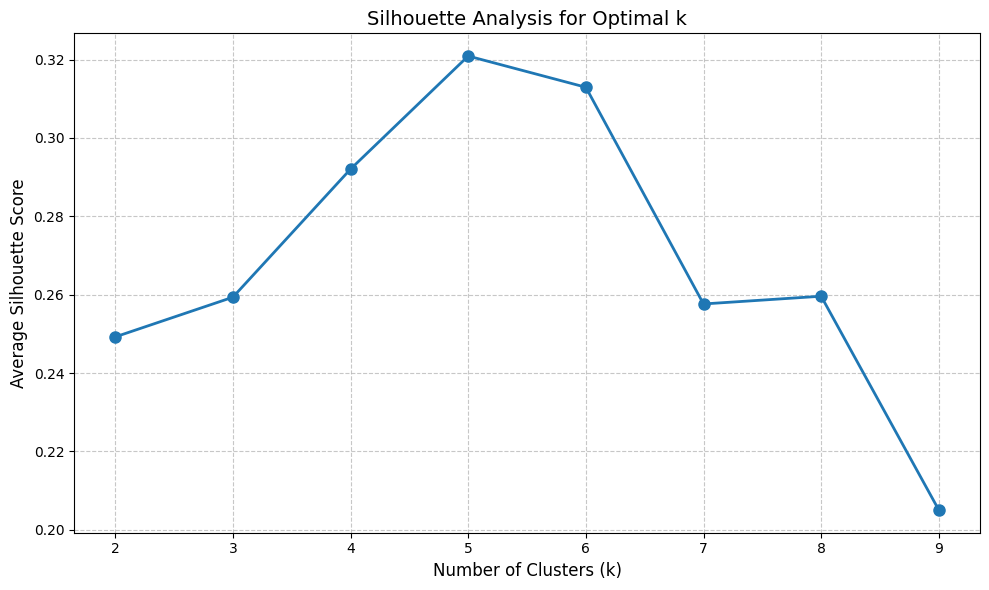

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for different values of k
silhouette_scores = []
k_range = range(2, 10)  # Silhouette score requires at least 2 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for Optimal k', fontsize=14)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Fetching color data...
Fetching sequence data...

Color Data Sample:
    color    r    g    b   matrice1 matrice  \
0    grey  170  170  170     Cover     lose   
1    pink  250    0   90  Category    place   
2    gold  250  200    0      Pull     hide   
3    nude  250  180  120  Approach     jump   
4  orange  250  110    0       Hit     drop   

                                    english-words    english-words-code  
0           respectful effective apposite precary               precary  
1             incredibily exquisite and ambitious             ambitious  
2  undepartable preflorating technocracy lotiform  technocracy lotiform  
3        felicitously deft satisfied unextenuable          unextenuable  
4                         blurry artesian awesome       blurry artesian  

Sequence Data Sample:
     ï»¿name                                           sequence
0       plot                     grey, pink, gold, nude, orange
1       knot  white, blue, green, red, black, brown, 

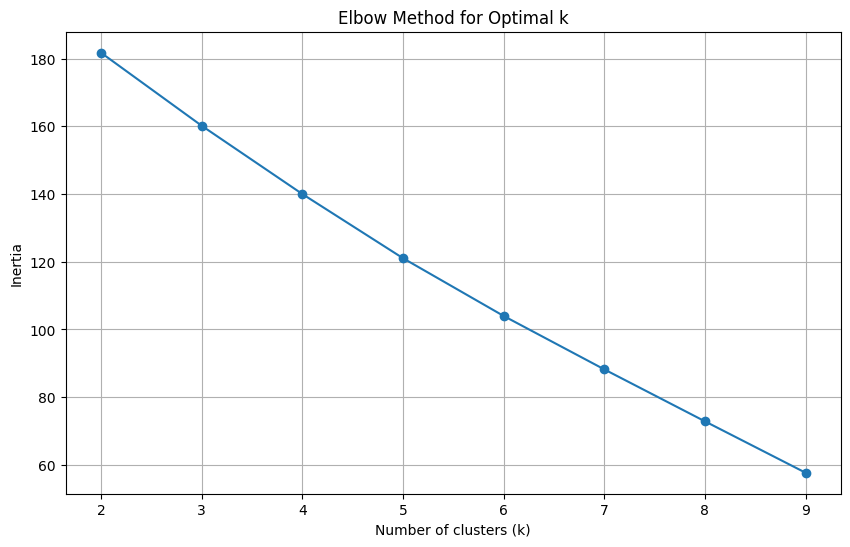

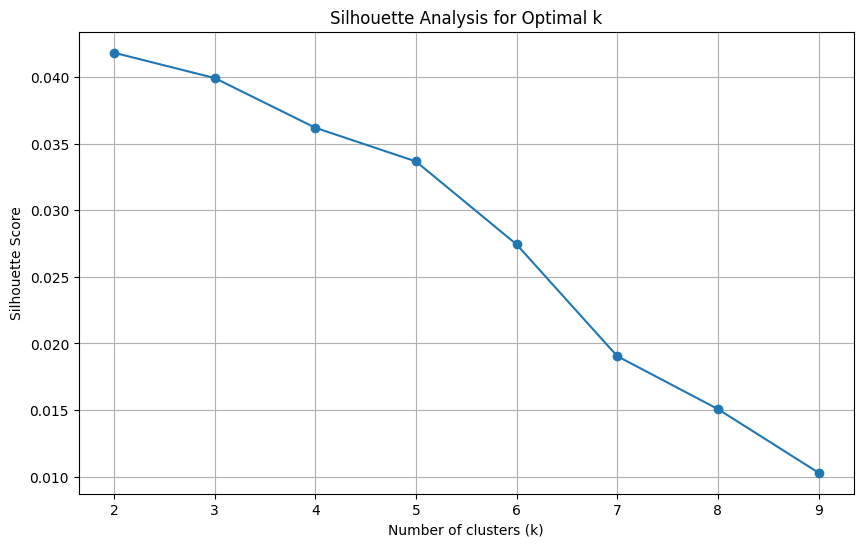

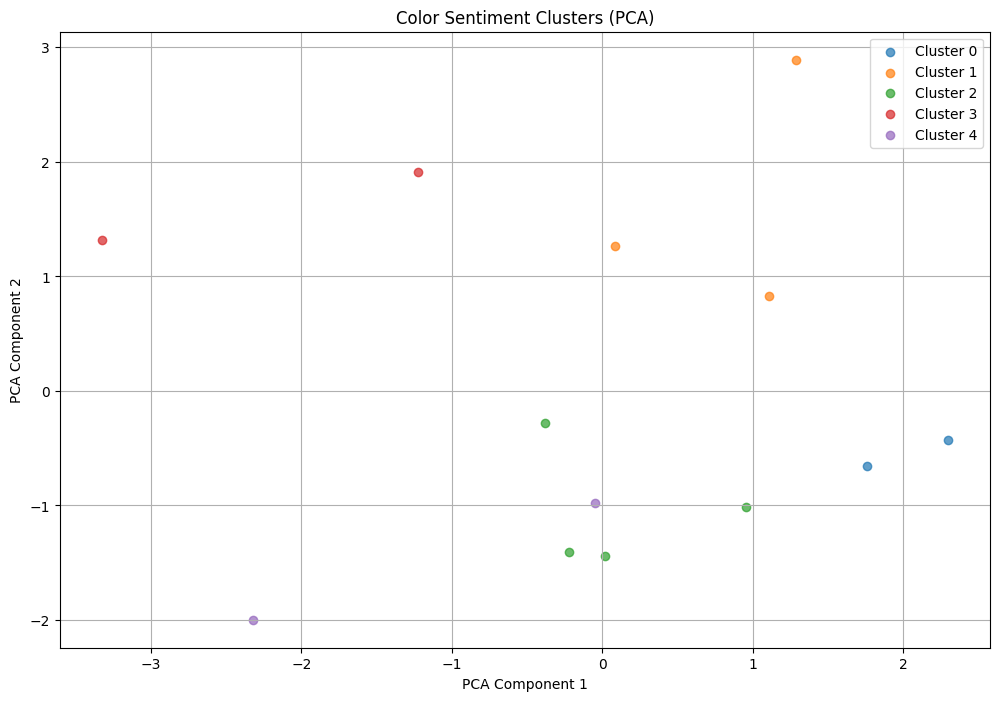

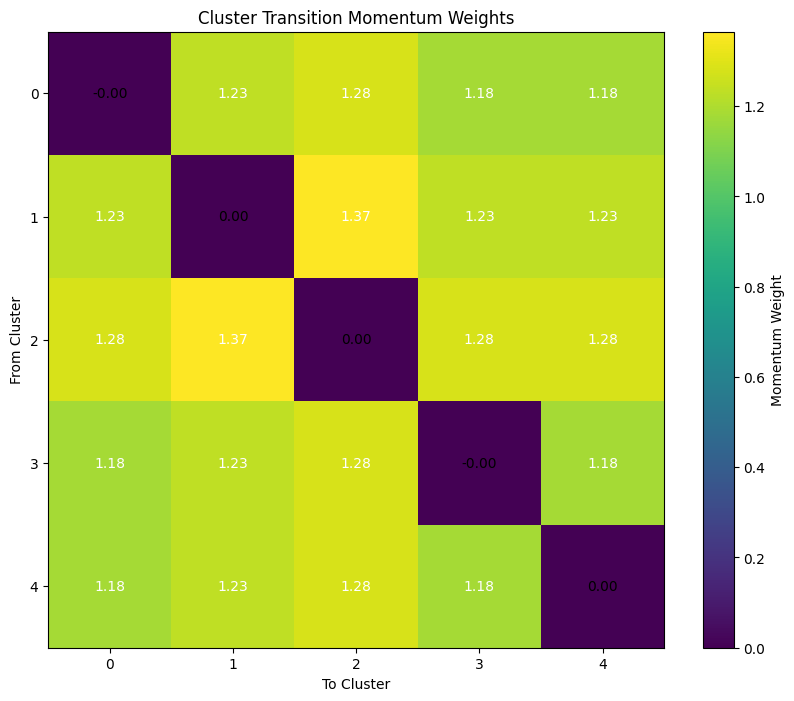

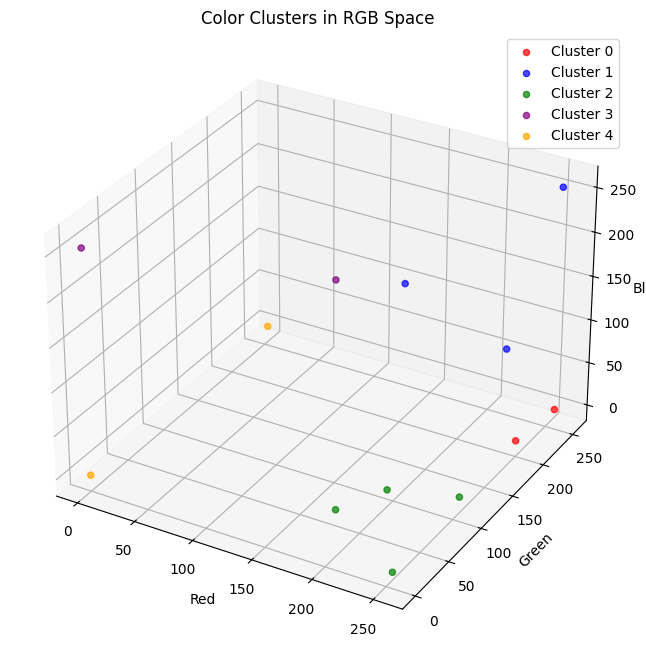

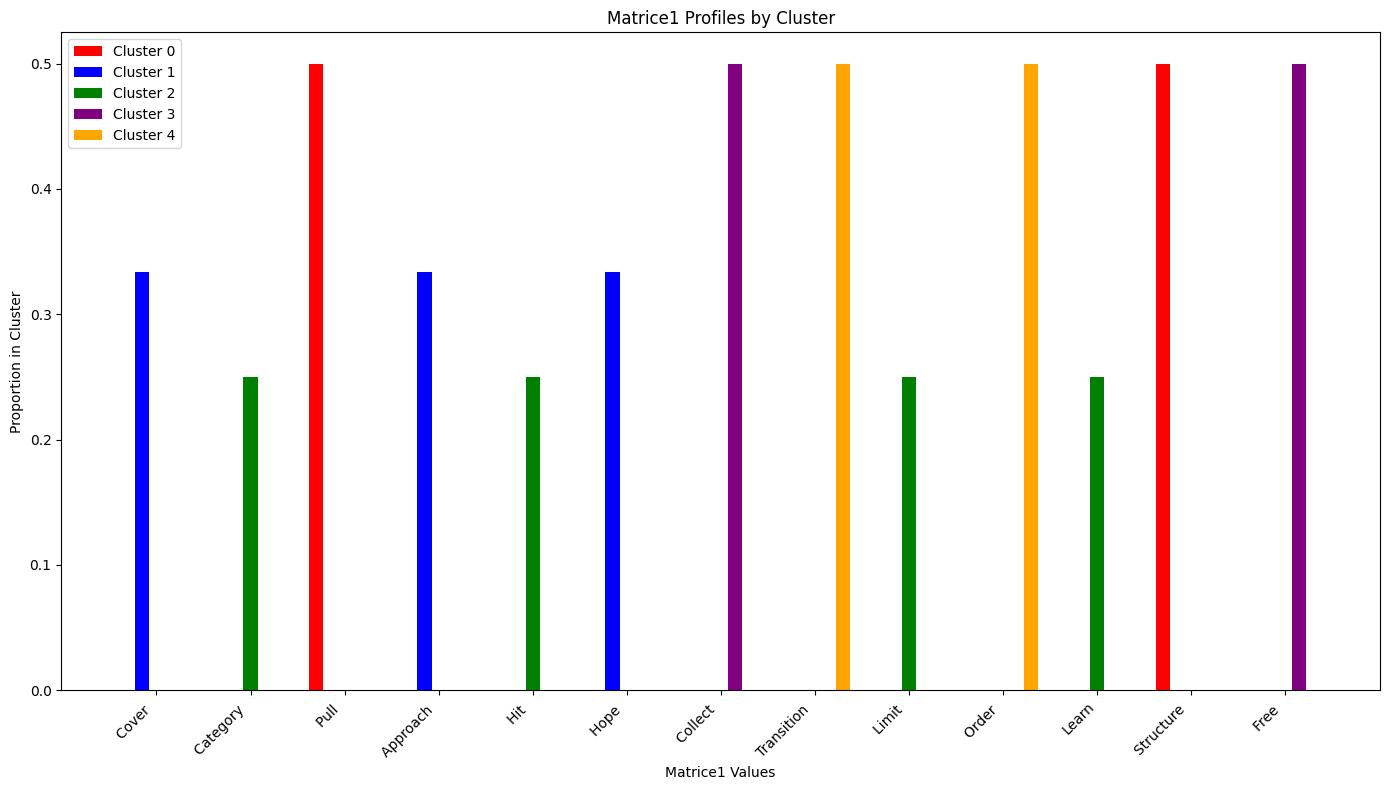

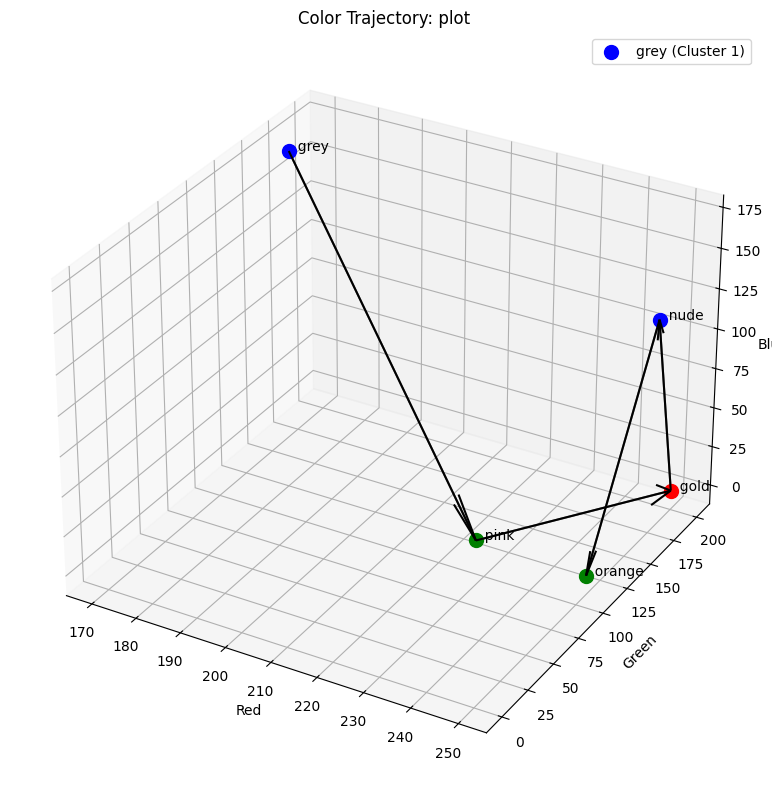

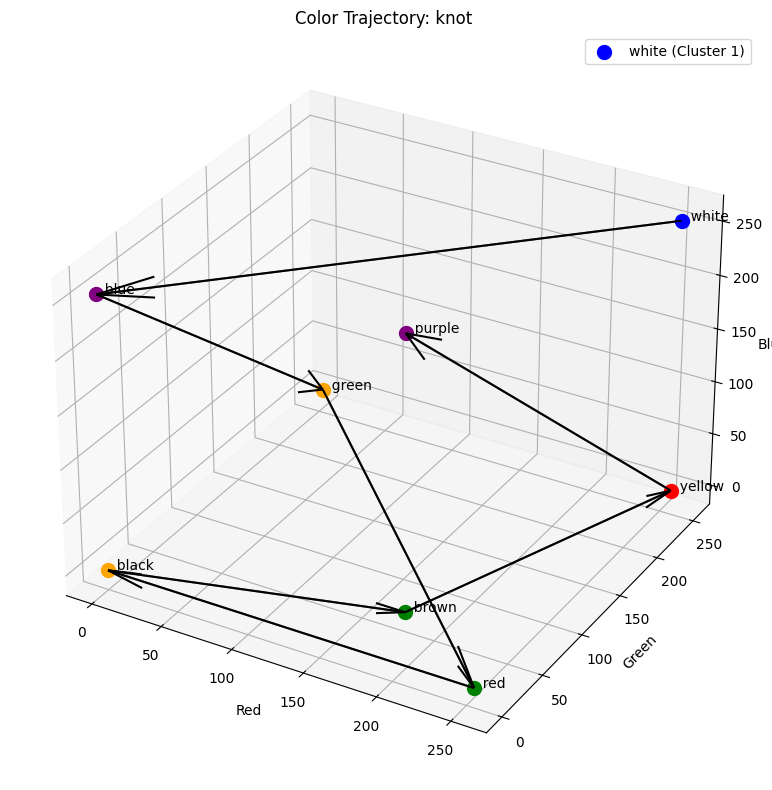

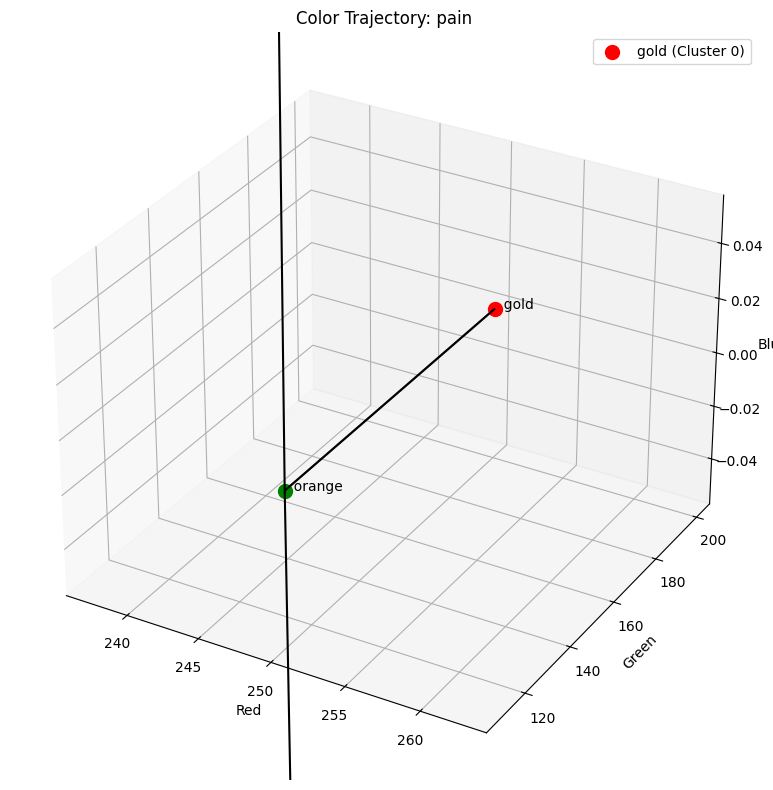

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import requests
from io import StringIO
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# URLs for the CSV files
colors_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice-qhiF8W1MZiXnmjlkL6xJasXeG1FryC.csv"
sequences_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice%20sequences-2j9pbWxr7vXA22q5VUTWXYgyaSe9dO.csv"

# Function to fetch and parse CSV data
def fetch_csv(url):
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Fetch the data
print("Fetching color data...")
colors_df = fetch_csv(colors_url)
print("Fetching sequence data...")
sequences_df = fetch_csv(sequences_url)

# Display the first few rows of each dataset
print("\nColor Data Sample:")
print(colors_df.head())
print("\nSequence Data Sample:")
print(sequences_df.head())

# Clean and prepare the color sentiment data
print("\nPreparing color sentiment data using 'matrice1' column...")

# Make sure RGB values are numeric
for col in ['r', 'g', 'b']:
    colors_df[col] = pd.to_numeric(colors_df[col], errors='coerce')

# Create one-hot encoding for matrice1 values
colors_df['matrice1'] = colors_df['matrice1'].fillna('Unknown').astype(str)
matrice1_dummies = pd.get_dummies(colors_df['matrice1'], prefix='matrice1')

# Combine RGB values with matrice1 features
X_rgb = colors_df[['r', 'g', 'b']].fillna(0)
X = pd.concat([X_rgb, matrice1_dummies], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
print("Determining optimal number of clusters...")

# Calculate silhouette scores
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)

# Choose k=5 based on analysis
k = 5
print(f"\nPerforming k-means clustering with k={k}...")
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
colors_df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for cluster in range(k):
    plt.scatter(
        X_pca[colors_df['cluster'] == cluster, 0],
        X_pca[colors_df['cluster'] == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title('Color Sentiment Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)

# Analyze the clusters
print("\nCluster Analysis:")
for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_colors)} colors):")
    print(f"  Common colors: {', '.join(cluster_colors['color'].value_counts().head(5).index.tolist())}")

    # Find most common matrice1 values in this cluster
    matrice1_counts = cluster_colors['matrice1'].value_counts().head(5)
    print(f"  Top matrice1 values: {', '.join(matrice1_counts.index.tolist())}")

    # Average RGB values for this cluster
    avg_rgb = cluster_colors[['r', 'g', 'b']].mean()
    print(f"  Average RGB: ({avg_rgb['r']:.1f}, {avg_rgb['g']:.1f}, {avg_rgb['b']:.1f})")

# Create a color-to-cluster mapping
color_to_cluster = dict(zip(colors_df['color'], colors_df['cluster']))

# Parse the sequences
print("\nAnalyzing color sequences...")
def parse_sequence(seq_str):
    if pd.isna(seq_str):
        return []
    return [color.strip().lower() for color in seq_str.split(',')]

sequences_df['parsed_sequence'] = sequences_df['sequence'].apply(parse_sequence)

# Calculate sequence momentum based on cluster transitions
def calculate_momentum(sequence, color_to_cluster, cluster_weights=None):
    if cluster_weights is None:
        # Default weights: transitions between different clusters have higher momentum
        cluster_weights = np.ones((k, k)) - np.eye(k)

    momentum = 0
    valid_transitions = 0

    for i in range(len(sequence) - 1):
        color1 = sequence[i]
        color2 = sequence[i + 1]

        # Skip if colors not in our dataset
        if color1 not in color_to_cluster or color2 not in color_to_cluster:
            continue

        cluster1 = color_to_cluster[color1]
        cluster2 = color_to_cluster[color2]

        # Add momentum based on cluster transition
        momentum += cluster_weights[cluster1, cluster2]
        valid_transitions += 1

    # Return average momentum per transition to normalize for sequence length
    return momentum / max(1, valid_transitions)

# Define cluster transition weights based on matrice1 similarity
# Calculate matrice1 similarity between clusters
cluster_centers = kmeans.cluster_centers_
# Extract just the matrice1 part of the cluster centers (not RGB)
matrice1_centers = cluster_centers[:, 3:]
# Calculate cosine similarity between matrice1 centers
matrice1_similarity = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        # Dot product of normalized vectors = cosine similarity
        norm_i = np.linalg.norm(matrice1_centers[i])
        norm_j = np.linalg.norm(matrice1_centers[j])
        if norm_i > 0 and norm_j > 0:
            matrice1_similarity[i, j] = np.dot(matrice1_centers[i], matrice1_centers[j]) / (norm_i * norm_j)
        else:
            matrice1_similarity[i, j] = 0

# Convert similarity to weights (higher similarity = lower momentum)
cluster_weights = 1 - matrice1_similarity

# Visualize the cluster transition weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cluster_weights, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Momentum Weight')
plt.title('Cluster Transition Momentum Weights')
plt.xlabel('To Cluster')
plt.ylabel('From Cluster')
for i in range(k):
    for j in range(k):
        plt.text(j, i, f'{cluster_weights[i, j]:.2f}',
                 ha='center', va='center',
                 color='white' if cluster_weights[i, j] > 0.5 else 'black')
plt.xticks(range(k))
plt.yticks(range(k))

# Calculate momentum for each sequence
sequences_df['momentum'] = sequences_df['parsed_sequence'].apply(
    lambda seq: calculate_momentum(seq, color_to_cluster, cluster_weights)
)

# Find sequences with highest and lowest momentum
print("\nSequences with Highest Momentum:")
high_momentum = sequences_df.sort_values('momentum', ascending=False).head(5)
for _, row in high_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

print("\nSequences with Lowest Momentum:")
low_momentum = sequences_df.sort_values('momentum').head(5)
for _, row in low_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

# Function to optimize a sequence by maximizing or minimizing momentum
def optimize_sequence(sequence, color_to_cluster, cluster_weights, maximize=True, iterations=100):
    colors_in_clusters = {}
    for color, cluster in color_to_cluster.items():
        if cluster not in colors_in_clusters:
            colors_in_clusters[cluster] = []
        colors_in_clusters[cluster].append(color)

    best_sequence = sequence.copy()
    best_momentum = calculate_momentum(best_sequence, color_to_cluster, cluster_weights)

    for _ in range(iterations):
        # Randomly select a position to modify
        if len(sequence) == 0:
            continue
        pos = np.random.randint(0, len(sequence))

        # Get current color and its cluster
        if sequence[pos] not in color_to_cluster:
            continue
        current_cluster = color_to_cluster[sequence[pos]]

        # Choose a random different cluster and a random color from it
        other_clusters = [c for c in range(k) if c != current_cluster and c in colors_in_clusters]
        if not other_clusters:
            continue
        new_cluster = np.random.choice(other_clusters)
        new_color = np.random.choice(colors_in_clusters[new_cluster])

        # Create a new sequence with the modified color
        new_sequence = sequence.copy()
        new_sequence[pos] = new_color

        # Calculate new momentum
        new_momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)

        # Update if better (higher momentum if maximizing, lower if minimizing)
        if (maximize and new_momentum > best_momentum) or (not maximize and new_momentum < best_momentum):
            best_sequence = new_sequence
            best_momentum = new_momentum

    return best_sequence, best_momentum

# Example: Optimize a sequence to maximize momentum
print("\nOptimizing Sequences:")
sample_sequence = sequences_df.iloc[0]['parsed_sequence']
if len(sample_sequence) > 0:
    print(f"Original sequence: {', '.join(sample_sequence)}")

    # Maximize momentum
    optimized_max, max_momentum = optimize_sequence(
        sample_sequence, color_to_cluster, cluster_weights, maximize=True
    )
    print(f"Optimized for maximum momentum: {', '.join(optimized_max)} (Momentum: {max_momentum:.2f})")

    # Minimize momentum
    optimized_min, min_momentum = optimize_sequence(
        sample_sequence, color_to_cluster, cluster_weights, maximize=False
    )
    print(f"Optimized for minimum momentum: {', '.join(optimized_min)} (Momentum: {min_momentum:.2f})")

# Create a function to generate new sequences based on matrice1 clusters
def generate_sequence_from_clusters(length, color_to_cluster, colors_in_clusters, target_clusters=None):
    if target_clusters is None:
        target_clusters = list(range(k))

    sequence = []
    for _ in range(length):
        # Choose a cluster from target clusters
        cluster = np.random.choice(target_clusters)

        # Choose a random color from that cluster
        if cluster in colors_in_clusters and colors_in_clusters[cluster]:
            color = np.random.choice(colors_in_clusters[cluster])
            sequence.append(color)

    return sequence

# Group colors by cluster
colors_in_clusters = {}
for color, cluster in color_to_cluster.items():
    if cluster not in colors_in_clusters:
        colors_in_clusters[cluster] = []
    colors_in_clusters[cluster].append(color)

# Generate new sequences based on specific matrice1 clusters
print("\nGenerating New Sequences Based on Matrice1 Clusters:")
for cluster in range(k):
    new_sequence = generate_sequence_from_clusters(5, color_to_cluster, colors_in_clusters, [cluster])
    momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)
    print(f"Sequence from Cluster {cluster}: {', '.join(new_sequence)} (Momentum: {momentum:.2f})")

# Generate a sequence with maximum expected momentum
print("\nGenerating a Sequence with Maximum Expected Momentum:")
# Find cluster pairs with highest weights
flat_weights = cluster_weights.flatten()
top_indices = np.argsort(flat_weights)[-5:]  # Top 5 transitions
top_pairs = [(idx // k, idx % k) for idx in top_indices]

# Create a sequence alternating between these clusters
high_momentum_sequence = []
for _ in range(5):  # Generate a sequence of length 10
    pair = top_pairs[np.random.randint(0, len(top_pairs))]
    if pair[0] in colors_in_clusters and colors_in_clusters[pair[0]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[0]]))
    if pair[1] in colors_in_clusters and colors_in_clusters[pair[1]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[1]]))

momentum = calculate_momentum(high_momentum_sequence, color_to_cluster, cluster_weights)
print(f"High momentum sequence: {', '.join(high_momentum_sequence)} (Momentum: {momentum:.2f})")

# Visualize the clusters in RGB space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of distinct colors for visualization
viz_colors = ['red', 'blue', 'green', 'purple', 'orange']

for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    ax.scatter(
        cluster_colors['r'],
        cluster_colors['g'],
        cluster_colors['b'],
        color=viz_colors[cluster % len(viz_colors)],
        label=f'Cluster {cluster}',
        alpha=0.7
    )

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('Color Clusters in RGB Space')
plt.legend()

# Create a visualization of cluster matrice1 profiles
# Get all unique matrice1 values
unique_matrice1 = colors_df['matrice1'].unique()
matrice1_counts = np.zeros((k, len(unique_matrice1)))

for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    for i, matrice1 in enumerate(unique_matrice1):
        matrice1_counts[cluster, i] = (cluster_colors['matrice1'] == matrice1).sum() / len(cluster_colors)

# Plot matrice1 profiles
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = np.arange(len(unique_matrice1))

for i in range(k):
    plt.bar(index + i * bar_width, matrice1_counts[i], bar_width,
            label=f'Cluster {i}', color=viz_colors[i % len(viz_colors)])

plt.xlabel('Matrice1 Values')
plt.ylabel('Proportion in Cluster')
plt.title('Matrice1 Profiles by Cluster')
plt.xticks(index + bar_width * (k-1)/2, unique_matrice1, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Create a visualization of the emotional trajectory of sequences
def plot_sequence_trajectory(sequence_name, sequence, color_to_cluster):
    valid_colors = [color for color in sequence if color in color_to_cluster]
    if len(valid_colors) < 2:
        return

    clusters = [color_to_cluster[color] for color in valid_colors]

    # Get RGB values for each color
    rgb_values = []
    for color in valid_colors:
        color_row = colors_df[colors_df['color'] == color].iloc[0]
        rgb_values.append((color_row['r'], color_row['g'], color_row['b']))

    # Plot the trajectory in RGB space
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    for i, (r, g, b) in enumerate(rgb_values):
        ax.scatter(r, g, b, color=viz_colors[clusters[i]], s=100, label=f'{valid_colors[i]} (Cluster {clusters[i]})' if i == 0 else "")

    # Plot lines connecting points
    for i in range(len(rgb_values) - 1):
        ax.plot([rgb_values[i][0], rgb_values[i+1][0]],
                [rgb_values[i][1], rgb_values[i+1][1]],
                [rgb_values[i][2], rgb_values[i+1][2]],
                'k-', alpha=0.5)

    # Add arrows to show direction
    for i in range(len(rgb_values) - 1):
        ax.quiver(rgb_values[i][0], rgb_values[i][1], rgb_values[i][2],
                 rgb_values[i+1][0] - rgb_values[i][0],
                 rgb_values[i+1][1] - rgb_values[i][1],
                 rgb_values[i+1][2] - rgb_values[i][2],
                 color='black', arrow_length_ratio=0.1)

    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title(f'Color Trajectory: {sequence_name}')

    # Add color names as annotations
    for i, (r, g, b) in enumerate(rgb_values):
        ax.text(r, g, b, f'  {valid_colors[i]}', size=10)

    plt.legend()
    plt.tight_layout()

# Plot trajectories for a few example sequences
print("\nPlotting color trajectories for example sequences...")
for _, row in sequences_df.head(3).iterrows():
    plot_sequence_trajectory(row['ï»¿name'], row['parsed_sequence'], color_to_cluster)

print("\nAnalysis complete!")

Fetching color data...
Fetching sequence data...

Color Data Sample:
    color    r    g    b   matrice1 matrice  \
0    grey  170  170  170     Cover     lose   
1    pink  250    0   90  Category    place   
2    gold  250  200    0      Pull     hide   
3    nude  250  180  120  Approach     jump   
4  orange  250  110    0       Hit     drop   

                                    english-words    english-words-code  
0           respectful effective apposite precary               precary  
1             incredibily exquisite and ambitious             ambitious  
2  undepartable preflorating technocracy lotiform  technocracy lotiform  
3        felicitously deft satisfied unextenuable          unextenuable  
4                         blurry artesian awesome       blurry artesian  

Sequence Data Sample:
     ï»¿name                                           sequence
0       plot                     grey, pink, gold, nude, orange
1       knot  white, blue, green, red, black, brown, 

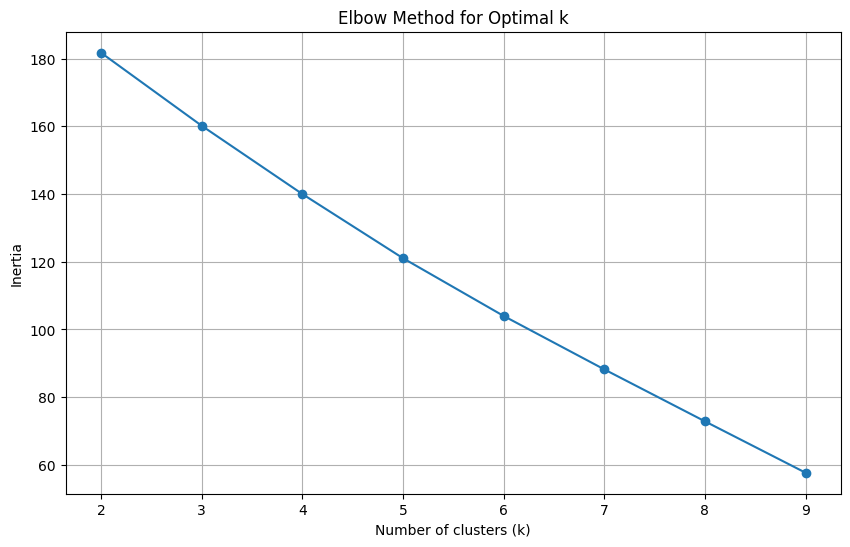

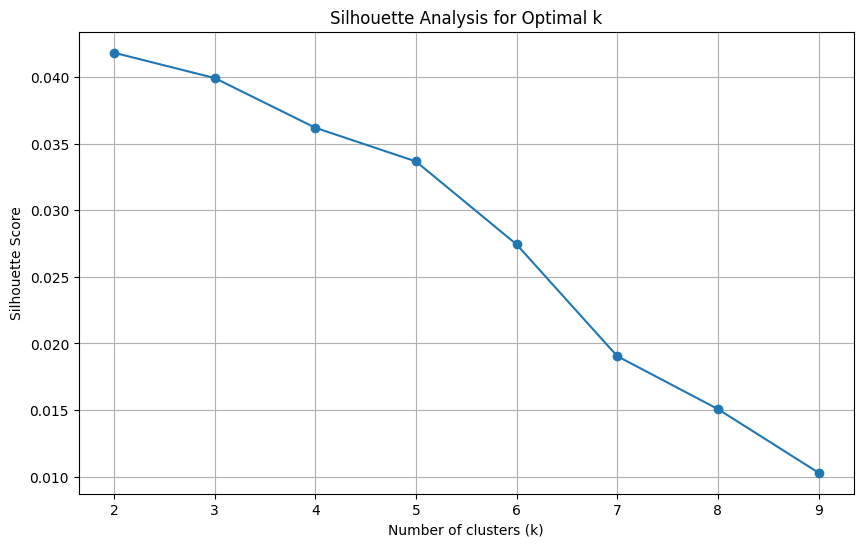

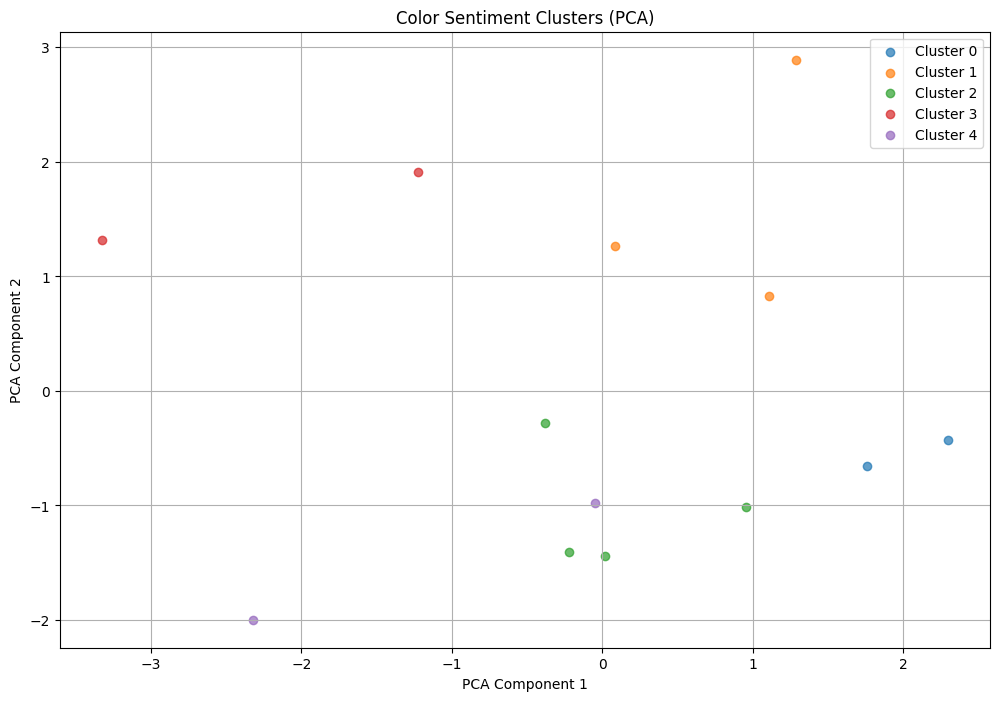

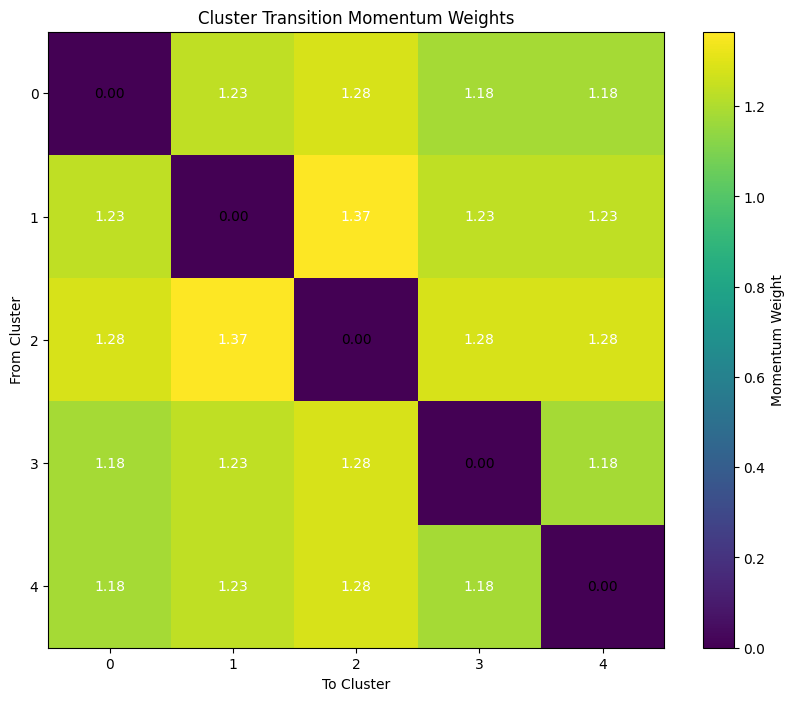

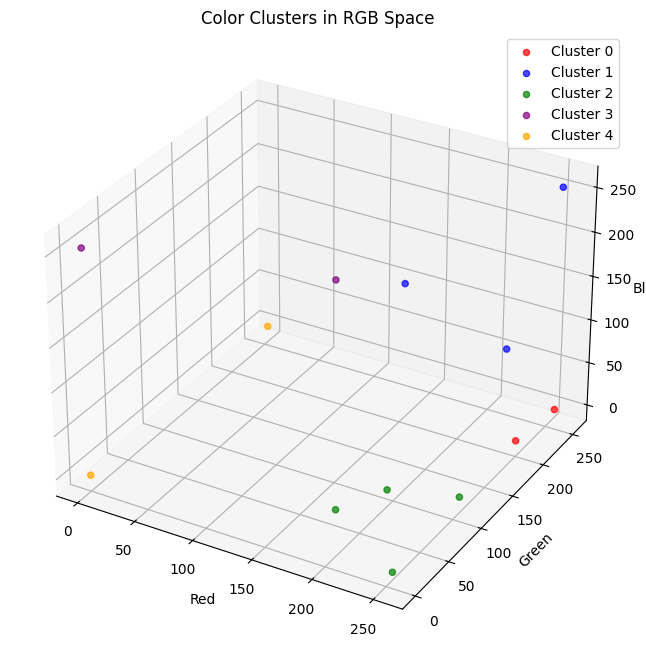

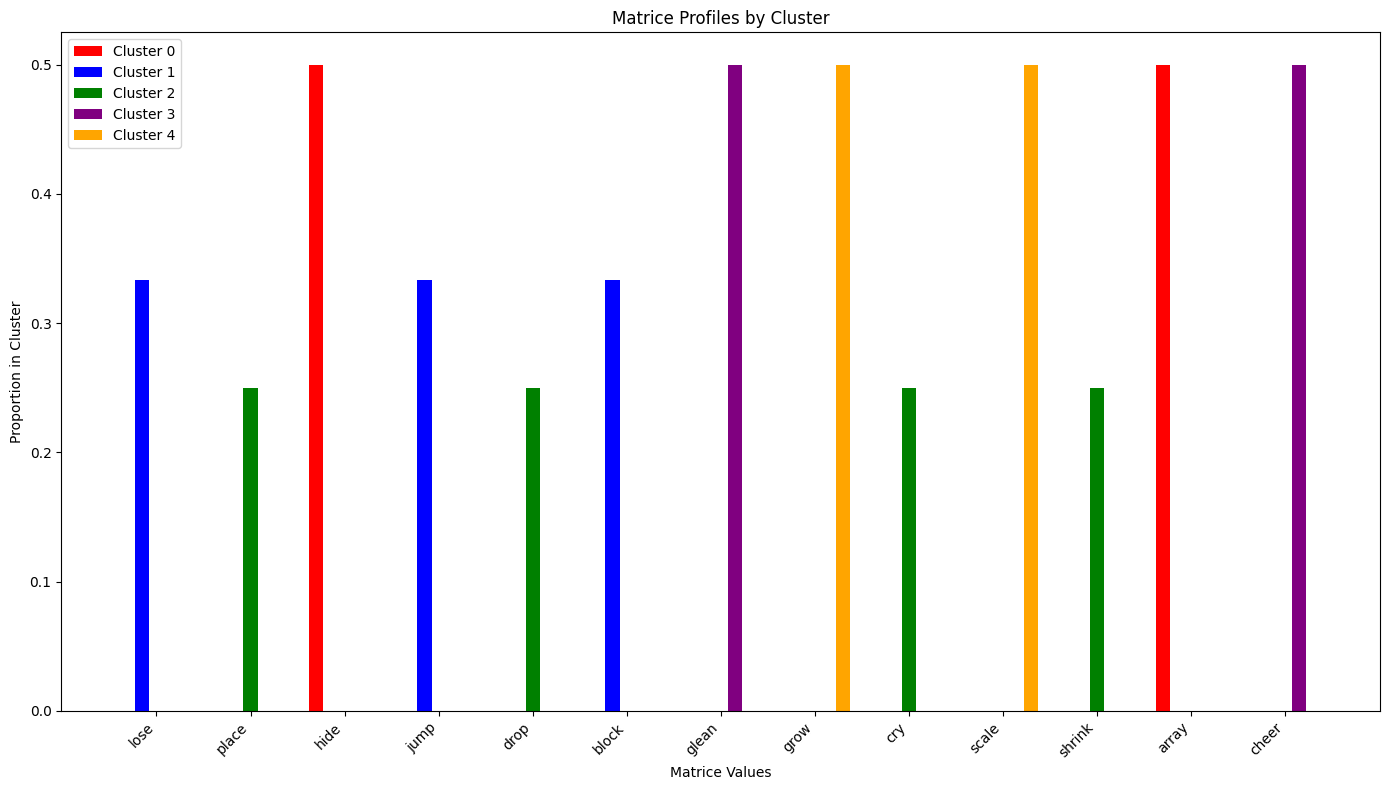

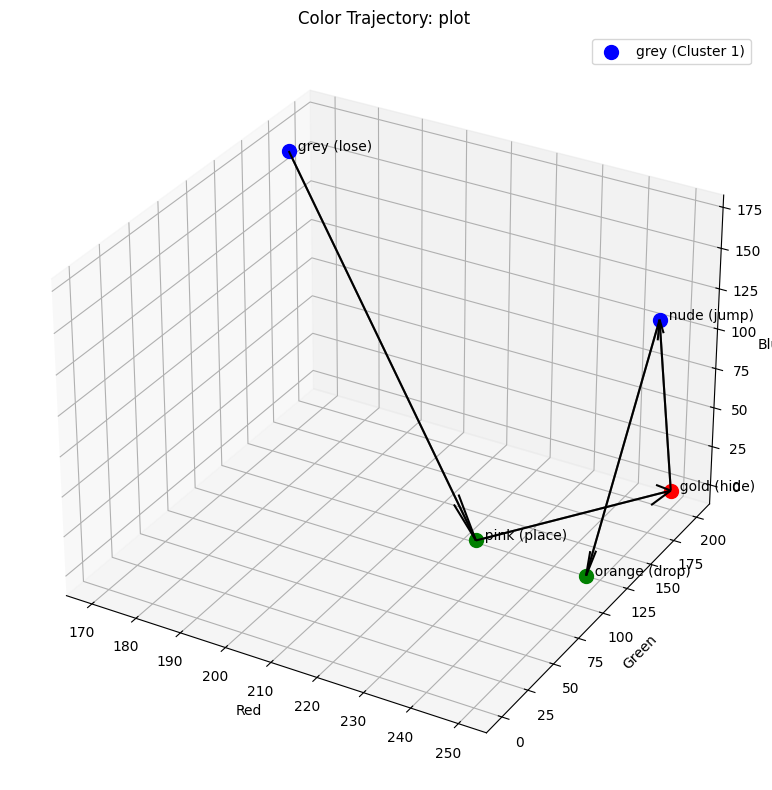

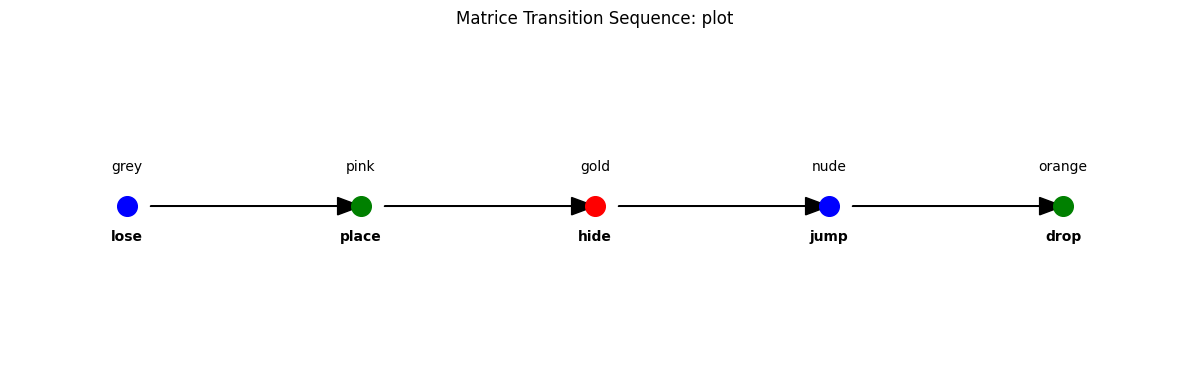

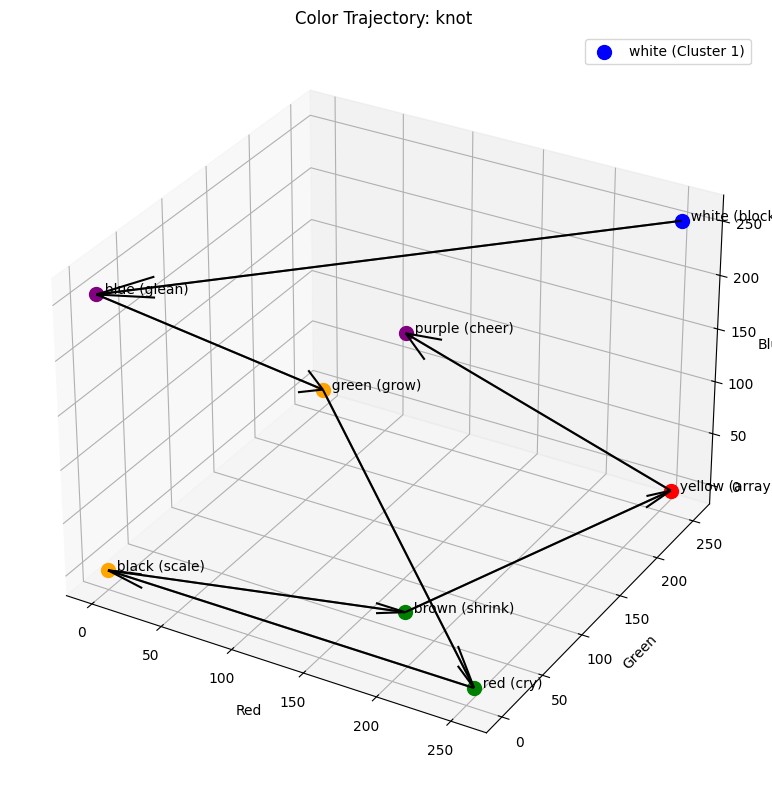

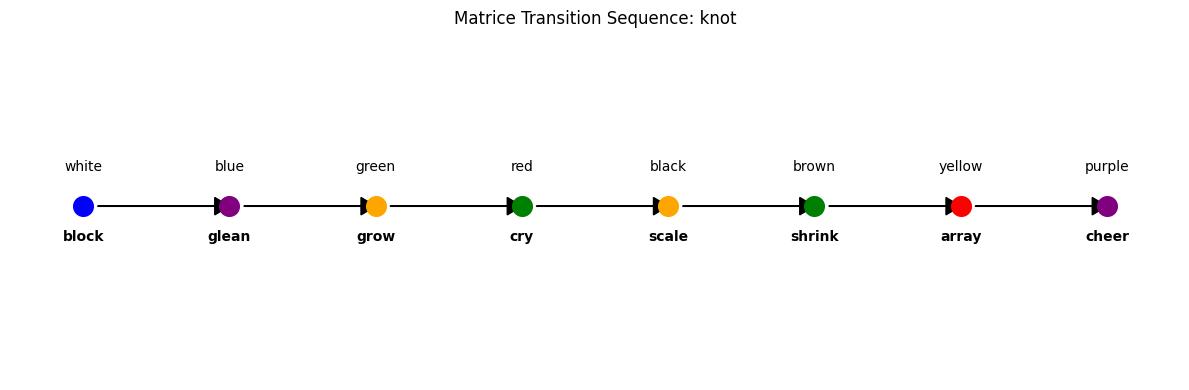

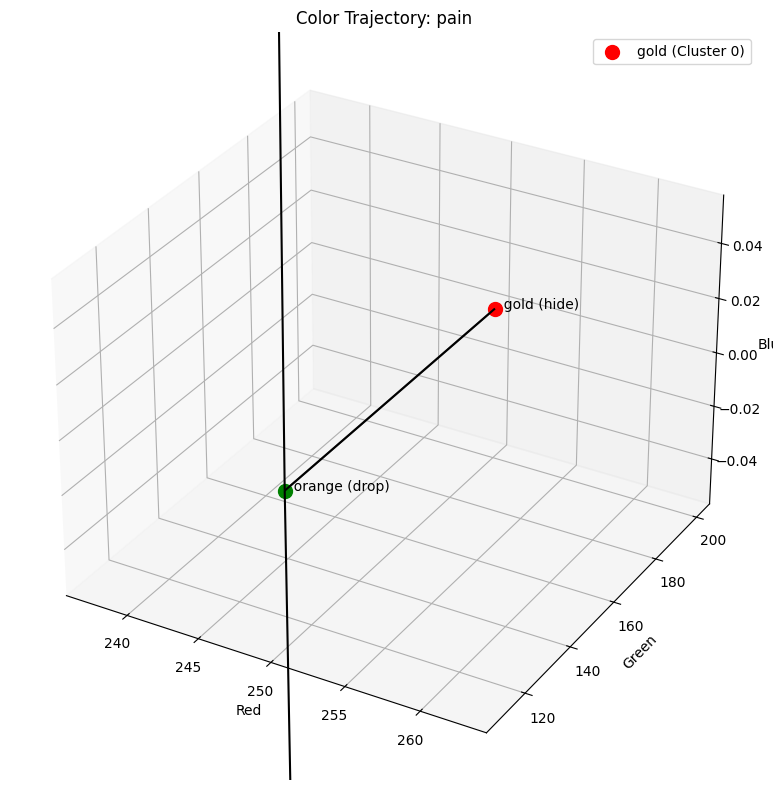

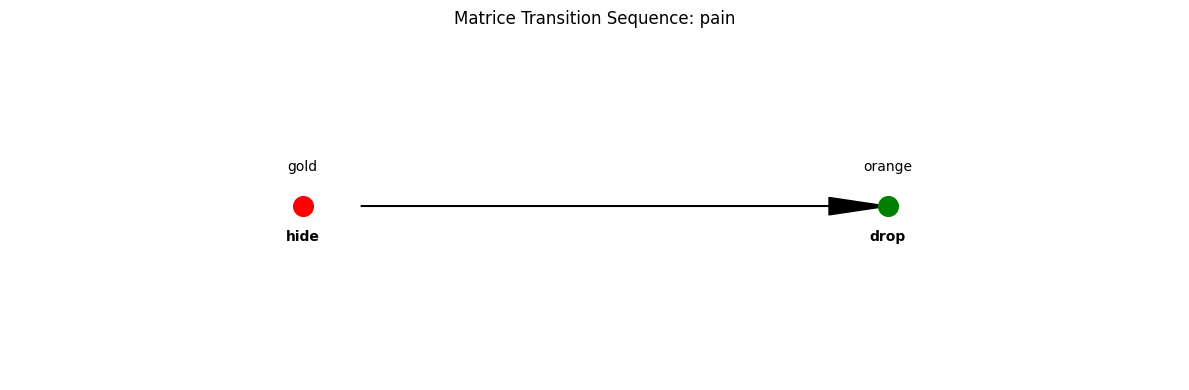

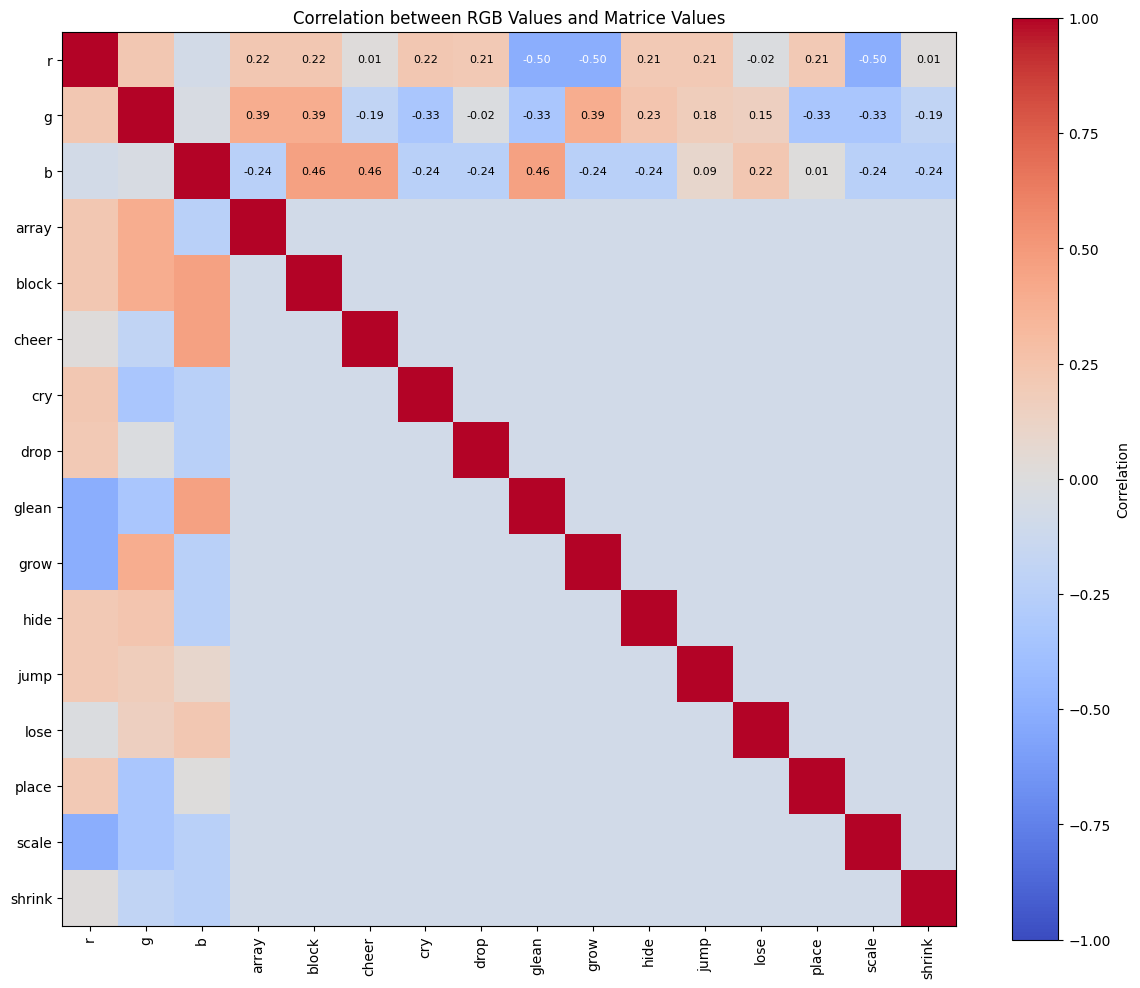

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import requests
from io import StringIO
import re
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# URLs for the CSV files
colors_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice-qhiF8W1MZiXnmjlkL6xJasXeG1FryC.csv"
sequences_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice%20sequences-2j9pbWxr7vXA22q5VUTWXYgyaSe9dO.csv"

# Function to fetch and parse CSV data
def fetch_csv(url):
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Fetch the data
print("Fetching color data...")
colors_df = fetch_csv(colors_url)
print("Fetching sequence data...")
sequences_df = fetch_csv(sequences_url)

# Display the first few rows of each dataset
print("\nColor Data Sample:")
print(colors_df.head())
print("\nSequence Data Sample:")
print(sequences_df.head())

# Clean and prepare the color sentiment data
print("\nPreparing color sentiment data using 'matrice' column...")

# Make sure RGB values are numeric
for col in ['r', 'g', 'b']:
    colors_df[col] = pd.to_numeric(colors_df[col], errors='coerce')

# Create one-hot encoding for matrice values
colors_df['matrice'] = colors_df['matrice'].fillna('Unknown').astype(str)
matrice_dummies = pd.get_dummies(colors_df['matrice'], prefix='matrice')

# Combine RGB values with matrice features
X_rgb = colors_df[['r', 'g', 'b']].fillna(0)
X = pd.concat([X_rgb, matrice_dummies], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
print("Determining optimal number of clusters...")

# Calculate silhouette scores
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.grid(True)

# Choose k=5 based on analysis
k = 5
print(f"\nPerforming k-means clustering with k={k}...")
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
colors_df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for cluster in range(k):
    plt.scatter(
        X_pca[colors_df['cluster'] == cluster, 0],
        X_pca[colors_df['cluster'] == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title('Color Sentiment Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)

# Analyze the clusters
print("\nCluster Analysis:")
for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_colors)} colors):")
    print(f"  Common colors: {', '.join(cluster_colors['color'].value_counts().head(5).index.tolist())}")

    # Find most common matrice values in this cluster
    matrice_counts = cluster_colors['matrice'].value_counts().head(5)
    print(f"  Top matrice values: {', '.join(matrice_counts.index.tolist())}")

    # Average RGB values for this cluster
    avg_rgb = cluster_colors[['r', 'g', 'b']].mean()
    print(f"  Average RGB: ({avg_rgb['r']:.1f}, {avg_rgb['g']:.1f}, {avg_rgb['b']:.1f})")

# Create a color-to-cluster mapping
color_to_cluster = dict(zip(colors_df['color'], colors_df['cluster']))

# Parse the sequences
print("\nAnalyzing color sequences...")
def parse_sequence(seq_str):
    if pd.isna(seq_str):
        return []
    return [color.strip().lower() for color in seq_str.split(',')]

sequences_df['parsed_sequence'] = sequences_df['sequence'].apply(parse_sequence)

# Calculate sequence momentum based on cluster transitions
def calculate_momentum(sequence, color_to_cluster, cluster_weights=None):
    if cluster_weights is None:
        # Default weights: transitions between different clusters have higher momentum
        cluster_weights = np.ones((k, k)) - np.eye(k)

    momentum = 0
    valid_transitions = 0

    for i in range(len(sequence) - 1):
        color1 = sequence[i]
        color2 = sequence[i + 1]

        # Skip if colors not in our dataset
        if color1 not in color_to_cluster or color2 not in color_to_cluster:
            continue

        cluster1 = color_to_cluster[color1]
        cluster2 = color_to_cluster[color2]

        # Add momentum based on cluster transition
        momentum += cluster_weights[cluster1, cluster2]
        valid_transitions += 1

    # Return average momentum per transition to normalize for sequence length
    return momentum / max(1, valid_transitions)

# Define cluster transition weights based on matrice similarity
# Calculate matrice similarity between clusters
cluster_centers = kmeans.cluster_centers_
# Extract just the matrice part of the cluster centers (not RGB)
matrice_centers = cluster_centers[:, 3:]
# Calculate cosine similarity between matrice centers
matrice_similarity = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        # Dot product of normalized vectors = cosine similarity
        norm_i = np.linalg.norm(matrice_centers[i])
        norm_j = np.linalg.norm(matrice_centers[j])
        if norm_i > 0 and norm_j > 0:
            matrice_similarity[i, j] = np.dot(matrice_centers[i], matrice_centers[j]) / (norm_i * norm_j)
        else:
            matrice_similarity[i, j] = 0

# Convert similarity to weights (higher similarity = lower momentum)
cluster_weights = 1 - matrice_similarity

# Visualize the cluster transition weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cluster_weights, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Momentum Weight')
plt.title('Cluster Transition Momentum Weights')
plt.xlabel('To Cluster')
plt.ylabel('From Cluster')
for i in range(k):
    for j in range(k):
        plt.text(j, i, f'{cluster_weights[i, j]:.2f}',
                 ha='center', va='center',
                 color='white' if cluster_weights[i, j] > 0.5 else 'black')
plt.xticks(range(k))
plt.yticks(range(k))

# Calculate momentum for each sequence
sequences_df['momentum'] = sequences_df['parsed_sequence'].apply(
    lambda seq: calculate_momentum(seq, color_to_cluster, cluster_weights)
)

# Find sequences with highest and lowest momentum
print("\nSequences with Highest Momentum:")
high_momentum = sequences_df.sort_values('momentum', ascending=False).head(5)
for _, row in high_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

print("\nSequences with Lowest Momentum:")
low_momentum = sequences_df.sort_values('momentum').head(5)
for _, row in low_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

# Function to optimize a sequence by maximizing or minimizing momentum
def optimize_sequence(sequence, color_to_cluster, cluster_weights, maximize=True, iterations=100):
    colors_in_clusters = {}
    for color, cluster in color_to_cluster.items():
        if cluster not in colors_in_clusters:
            colors_in_clusters[cluster] = []
        colors_in_clusters[cluster].append(color)

    best_sequence = sequence.copy()
    best_momentum = calculate_momentum(best_sequence, color_to_cluster, cluster_weights)

    for _ in range(iterations):
        # Randomly select a position to modify
        if len(sequence) == 0:
            continue
        pos = np.random.randint(0, len(sequence))

        # Get current color and its cluster
        if sequence[pos] not in color_to_cluster:
            continue
        current_cluster = color_to_cluster[sequence[pos]]

        # Choose a random different cluster and a random color from it
        other_clusters = [c for c in range(k) if c != current_cluster and c in colors_in_clusters]
        if not other_clusters:
            continue
        new_cluster = np.random.choice(other_clusters)
        new_color = np.random.choice(colors_in_clusters[new_cluster])

        # Create a new sequence with the modified color
        new_sequence = sequence.copy()
        new_sequence[pos] = new_color

        # Calculate new momentum
        new_momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)

        # Update if better (higher momentum if maximizing, lower if minimizing)
        if (maximize and new_momentum > best_momentum) or (not maximize and new_momentum < best_momentum):
            best_sequence = new_sequence
            best_momentum = new_momentum

    return best_sequence, best_momentum

# Example: Optimize a sequence to maximize momentum
print("\nOptimizing Sequences:")
sample_sequence = sequences_df.iloc[0]['parsed_sequence']
if len(sample_sequence) > 0:
    print(f"Original sequence: {', '.join(sample_sequence)}")

    # Maximize momentum
    optimized_max, max_momentum = optimize_sequence(
        sample_sequence, color_to_cluster, cluster_weights, maximize=True
    )
    print(f"Optimized for maximum momentum: {', '.join(optimized_max)} (Momentum: {max_momentum:.2f})")

    # Minimize momentum
    optimized_min, min_momentum = optimize_sequence(
        sample_sequence, color_to_cluster, cluster_weights, maximize=False
    )
    print(f"Optimized for minimum momentum: {', '.join(optimized_min)} (Momentum: {min_momentum:.2f})")

# Create a function to generate new sequences based on matrice clusters
def generate_sequence_from_clusters(length, color_to_cluster, colors_in_clusters, target_clusters=None):
    if target_clusters is None:
        target_clusters = list(range(k))

    sequence = []
    for _ in range(length):
        # Choose a cluster from target clusters
        cluster = np.random.choice(target_clusters)

        # Choose a random color from that cluster
        if cluster in colors_in_clusters and colors_in_clusters[cluster]:
            color = np.random.choice(colors_in_clusters[cluster])
            sequence.append(color)

    return sequence

# Group colors by cluster
colors_in_clusters = {}
for color, cluster in color_to_cluster.items():
    if cluster not in colors_in_clusters:
        colors_in_clusters[cluster] = []
    colors_in_clusters[cluster].append(color)

# Generate new sequences based on specific matrice clusters
print("\nGenerating New Sequences Based on Matrice Clusters:")
for cluster in range(k):
    new_sequence = generate_sequence_from_clusters(5, color_to_cluster, colors_in_clusters, [cluster])
    momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)
    print(f"Sequence from Cluster {cluster}: {', '.join(new_sequence)} (Momentum: {momentum:.2f})")

# Generate a sequence with maximum expected momentum
print("\nGenerating a Sequence with Maximum Expected Momentum:")
# Find cluster pairs with highest weights
flat_weights = cluster_weights.flatten()
top_indices = np.argsort(flat_weights)[-5:]  # Top 5 transitions
top_pairs = [(idx // k, idx % k) for idx in top_indices]

# Create a sequence alternating between these clusters
high_momentum_sequence = []
for _ in range(5):  # Generate a sequence of length 10
    pair = top_pairs[np.random.randint(0, len(top_pairs))]
    if pair[0] in colors_in_clusters and colors_in_clusters[pair[0]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[0]]))
    if pair[1] in colors_in_clusters and colors_in_clusters[pair[1]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[1]]))

momentum = calculate_momentum(high_momentum_sequence, color_to_cluster, cluster_weights)
print(f"High momentum sequence: {', '.join(high_momentum_sequence)} (Momentum: {momentum:.2f})")

# Visualize the clusters in RGB space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a list of distinct colors for visualization
viz_colors = ['red', 'blue', 'green', 'purple', 'orange']

for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    ax.scatter(
        cluster_colors['r'],
        cluster_colors['g'],
        cluster_colors['b'],
        color=viz_colors[cluster % len(viz_colors)],
        label=f'Cluster {cluster}',
        alpha=0.7
    )

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('Color Clusters in RGB Space')
plt.legend()

# Create a visualization of cluster matrice profiles
# Get all unique matrice values
unique_matrice = colors_df['matrice'].unique()
matrice_counts = np.zeros((k, len(unique_matrice)))

for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    for i, matrice in enumerate(unique_matrice):
        matrice_counts[cluster, i] = (cluster_colors['matrice'] == matrice).sum() / len(cluster_colors)

# Plot matrice profiles
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = np.arange(len(unique_matrice))

for i in range(k):
    plt.bar(index + i * bar_width, matrice_counts[i], bar_width,
            label=f'Cluster {i}', color=viz_colors[i % len(viz_colors)])

plt.xlabel('Matrice Values')
plt.ylabel('Proportion in Cluster')
plt.title('Matrice Profiles by Cluster')
plt.xticks(index + bar_width * (k-1)/2, unique_matrice, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Create a visualization of the emotional trajectory of sequences
def plot_sequence_trajectory(sequence_name, sequence, color_to_cluster):
    valid_colors = [color for color in sequence if color in color_to_cluster]
    if len(valid_colors) < 2:
        return

    clusters = [color_to_cluster[color] for color in valid_colors]

    # Get RGB values for each color
    rgb_values = []
    matrice_values = []
    for color in valid_colors:
        color_row = colors_df[colors_df['color'] == color].iloc[0]
        rgb_values.append((color_row['r'], color_row['g'], color_row['b']))
        matrice_values.append(color_row['matrice'])

    # Plot the trajectory in RGB space
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    for i, (r, g, b) in enumerate(rgb_values):
        ax.scatter(r, g, b, color=viz_colors[clusters[i]], s=100, label=f'{valid_colors[i]} (Cluster {clusters[i]})' if i == 0 else "")

    # Plot lines connecting points
    for i in range(len(rgb_values) - 1):
        ax.plot([rgb_values[i][0], rgb_values[i+1][0]],
                [rgb_values[i][1], rgb_values[i+1][1]],
                [rgb_values[i][2], rgb_values[i+1][2]],
                'k-', alpha=0.5)

    # Add arrows to show direction
    for i in range(len(rgb_values) - 1):
        ax.quiver(rgb_values[i][0], rgb_values[i][1], rgb_values[i][2],
                 rgb_values[i+1][0] - rgb_values[i][0],
                 rgb_values[i+1][1] - rgb_values[i][1],
                 rgb_values[i+1][2] - rgb_values[i][2],
                 color='black', arrow_length_ratio=0.1)

    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title(f'Color Trajectory: {sequence_name}')

    # Add color names and matrice values as annotations
    for i, (r, g, b) in enumerate(rgb_values):
        ax.text(r, g, b, f'  {valid_colors[i]} ({matrice_values[i]})', size=10)

    plt.legend()
    plt.tight_layout()

    # Create a second plot showing the matrice transitions
    plt.figure(figsize=(12, 4))
    for i in range(len(valid_colors)):
        plt.scatter(i, 0, s=200, color=viz_colors[clusters[i]])
        plt.text(i, 0.1, valid_colors[i], ha='center')
        plt.text(i, -0.1, matrice_values[i], ha='center', fontweight='bold')

        if i < len(valid_colors) - 1:
            plt.arrow(i + 0.1, 0, 0.8, 0, head_width=0.05, head_length=0.1, fc='black', ec='black')

    plt.ylim(-0.5, 0.5)
    plt.xlim(-0.5, len(valid_colors) - 0.5)
    plt.axis('off')
    plt.title(f'Matrice Transition Sequence: {sequence_name}')
    plt.tight_layout()

# Plot trajectories for a few example sequences
print("\nPlotting color trajectories for example sequences...")
for _, row in sequences_df.head(3).iterrows():
    plot_sequence_trajectory(row['ï»¿name'], row['parsed_sequence'], color_to_cluster)

# Create a correlation matrix between RGB values and matrice values
# First, create dummy variables for matrice
matrice_dummies = pd.get_dummies(colors_df['matrice'])

# Combine with RGB values
rgb_matrice_df = pd.concat([colors_df[['r', 'g', 'b']], matrice_dummies], axis=1)

# Calculate correlation matrix
corr_matrix = rgb_matrice_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation between RGB Values and Matrice Values')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Add correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        if i < 3 and j >= 3:  # Only show RGB to matrice correlations
            plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                    ha='center', va='center',
                    color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                    fontsize=8)

plt.tight_layout()

print("\nAnalysis complete!")

# The below code is used to input constraints and find optimal sequences

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=61013bbefcf2fc4c7bec309d50d92a0172b8dade5c757e20daa82aff38cb38dc
  Stored in directory: /root/.cache/pip/wheels/f5/ce/f7/7039d7b57e1a27fc2f6bb2b2abed1be362eefece03caf2fb9a
Successfully built colormath
Fetching color data...
Fetching sequence data...
Fetching semantic RGB mapping data...

Color Data Sample:
    color    r    g    b   matrice1 matrice  \
0    grey  170  170  170     Cover     lose   
1    pink  250    0   90  Category    place   
2    gold  250  200    0      Pull     hide   
3    nude  250  180  120  Approach     jump   
4  orange  250  110    0       Hit     drop   

                                    english-words    english-words-code  
0           respectful effective apposite precary               precary  
1             incredibily exquisite and ambitious             ambitious  
2  undepartable preflorating technocracy lotiform  tech

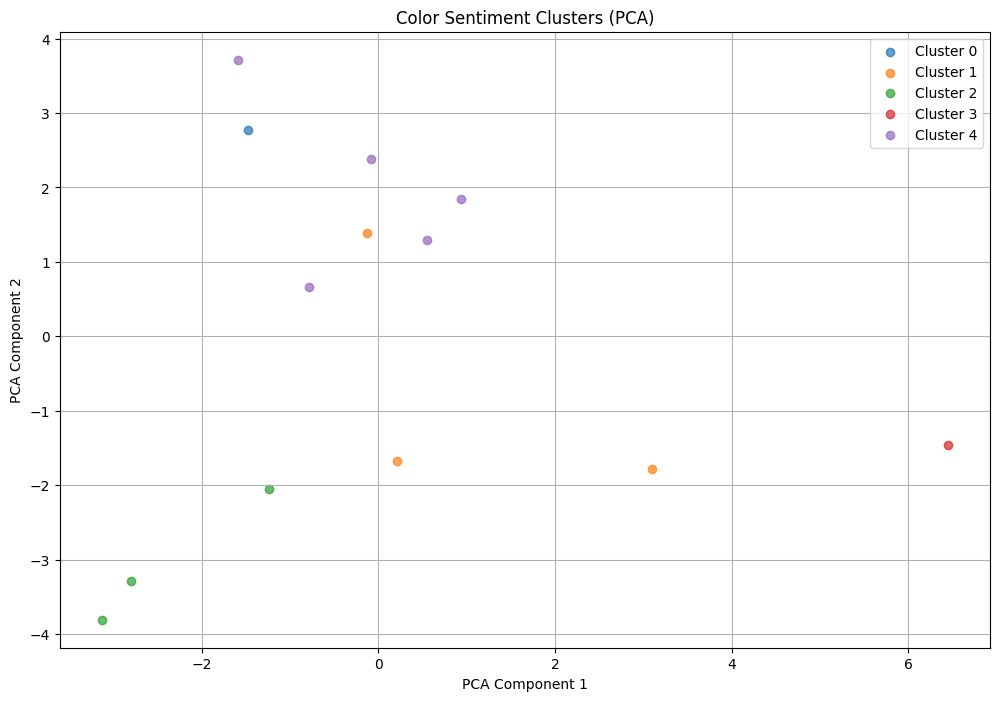

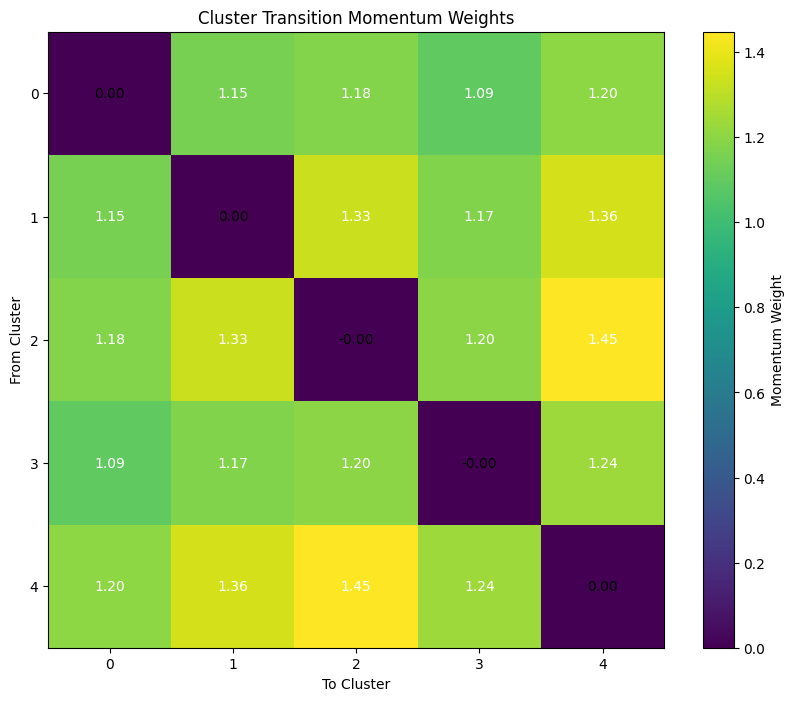

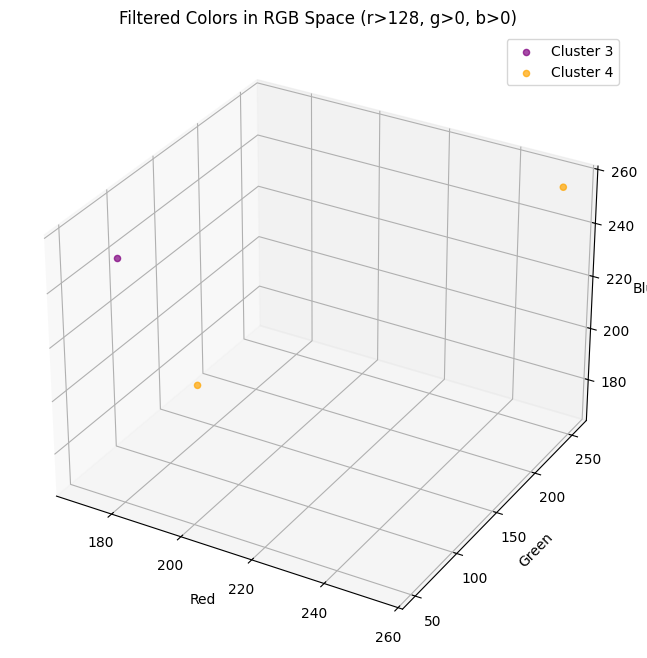

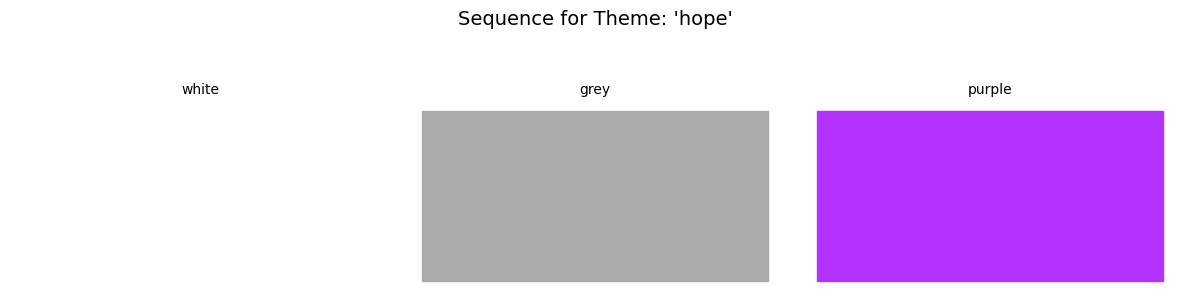

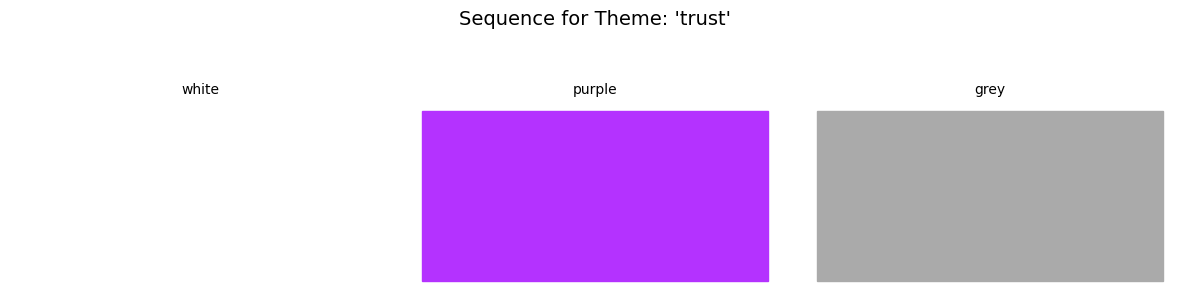

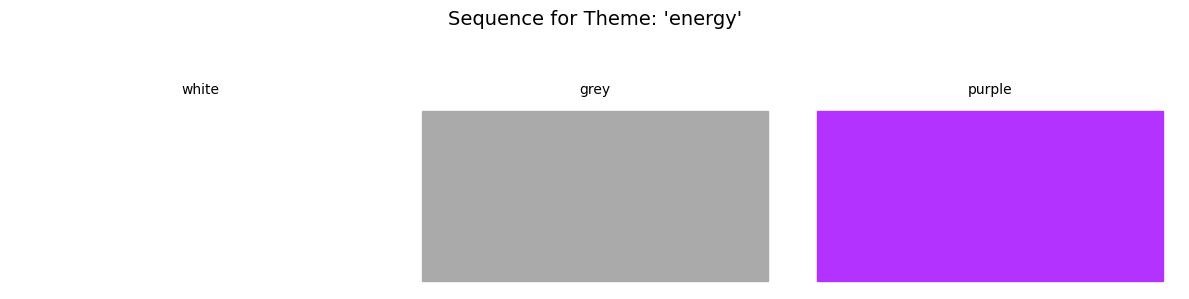

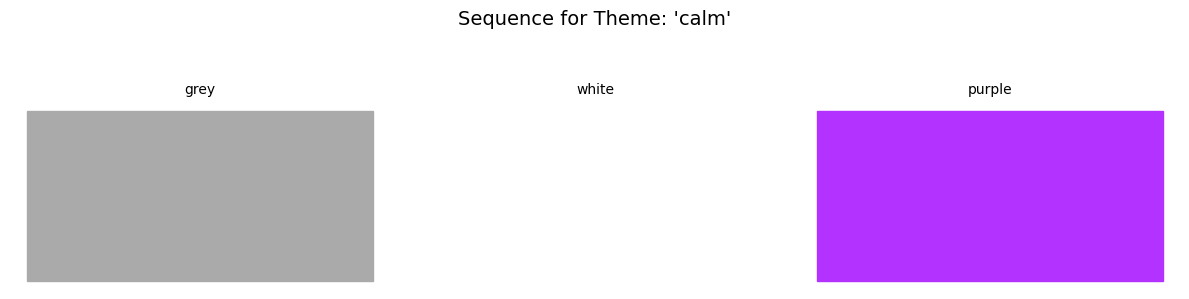

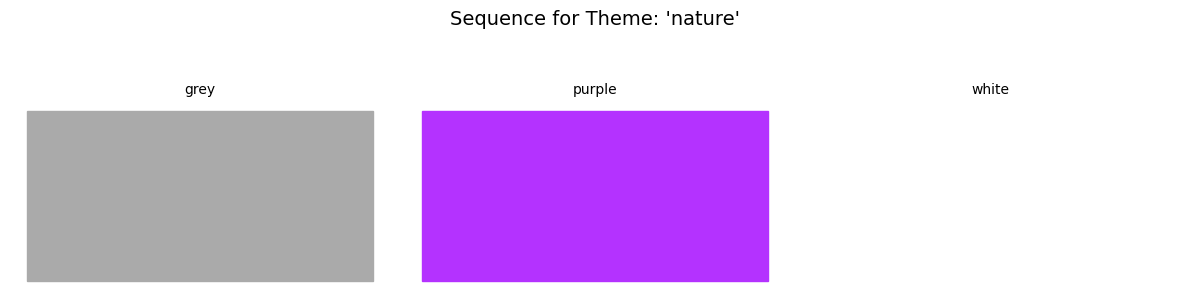

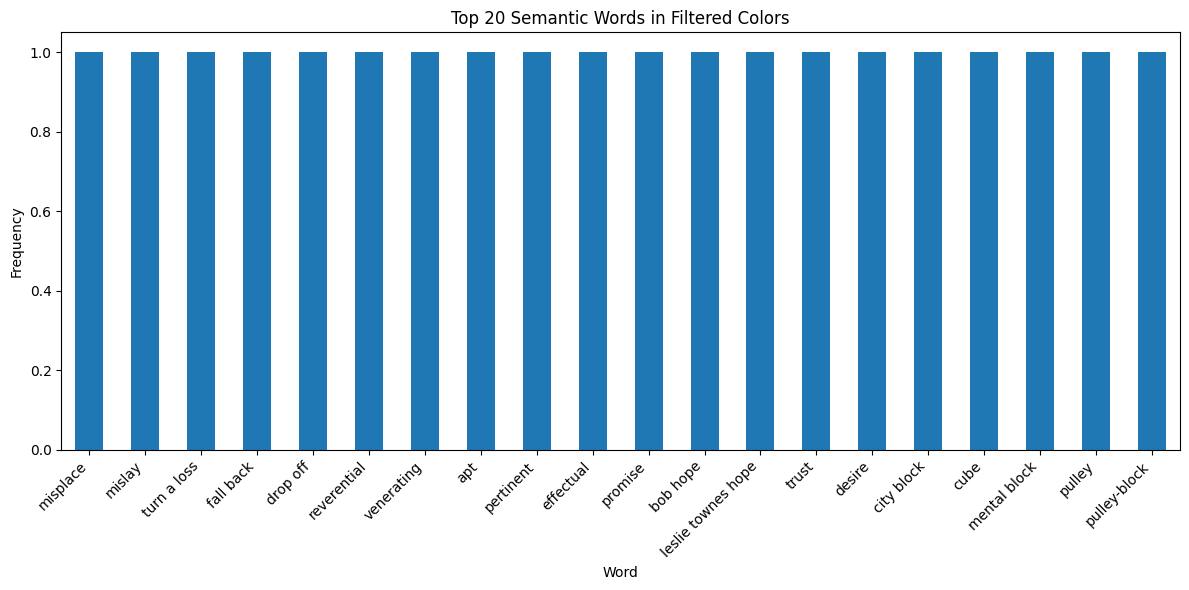

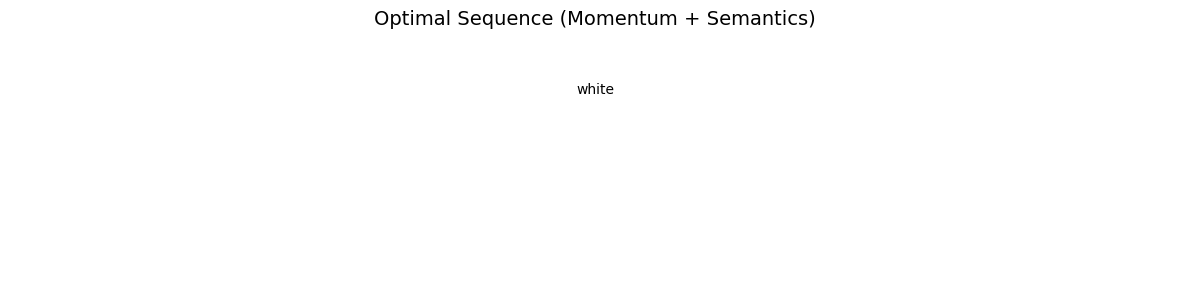

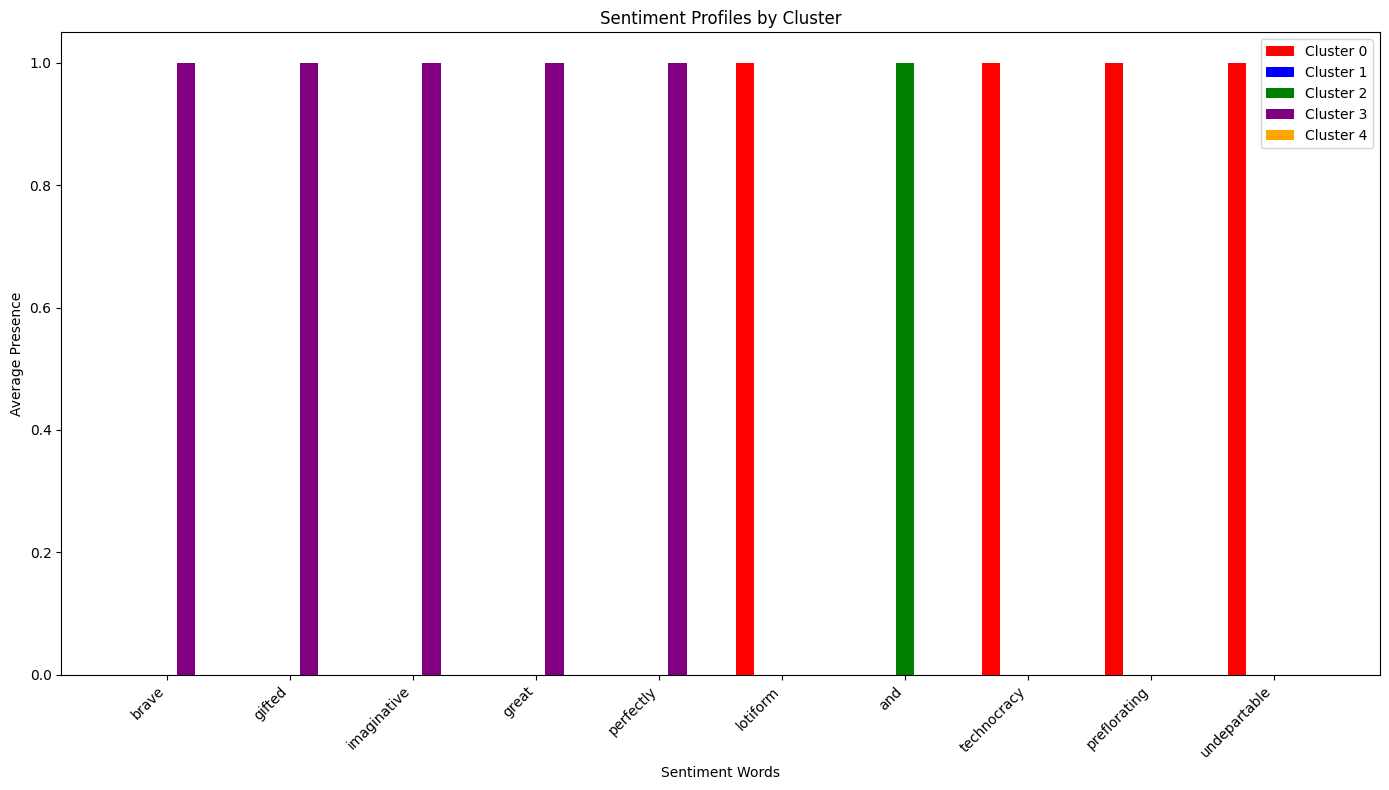

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import requests
from io import StringIO
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import random
import math

# Install colormath package
!pip install colormath

# Import colormath after installation
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

# URLs for the CSV files
colors_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice-qhiF8W1MZiXnmjlkL6xJasXeG1FryC.csv"
sequences_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice%20sequences-2j9pbWxr7vXA22q5VUTWXYgyaSe9dO.csv"
semantic_mapping_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/semantic_rgb_mapping-3wPDXdwfqLO8Vfft8r0P9WUC5Squqk.csv"

# Function to fetch and parse CSV data
def fetch_csv(url):
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Fetch the data
print("Fetching color data...")
colors_df = fetch_csv(colors_url)
print("Fetching sequence data...")
sequences_df = fetch_csv(sequences_url)
print("Fetching semantic RGB mapping data...")
semantic_mapping_df = fetch_csv(semantic_mapping_url)

# Display the first few rows of each dataset
print("\nColor Data Sample:")
print(colors_df.head())
print("\nSequence Data Sample:")
print(sequences_df.head())
print("\nSemantic RGB Mapping Sample:")
print(semantic_mapping_df.head())

# Clean and prepare the color sentiment data
print("\nPreparing color sentiment data...")

# Make sure RGB values are numeric
for col in ['r', 'g', 'b']:
    colors_df[col] = pd.to_numeric(colors_df[col], errors='coerce')

# Convert RGB columns to numeric in the semantic mapping
for col in ['R', 'G', 'B']:
    semantic_mapping_df[col] = pd.to_numeric(semantic_mapping_df[col], errors='coerce')

# Extract sentiment features using text vectorization
# First, clean the english-words column
colors_df['clean_words'] = colors_df['english-words'].fillna('').astype(str)

# Use CountVectorizer to create binary features for sentiment words
vectorizer = CountVectorizer(binary=True, max_features=100)
sentiment_features = vectorizer.fit_transform(colors_df['clean_words'])
sentiment_df = pd.DataFrame(
    sentiment_features.toarray(),
    columns=[f'sentiment_{word}' for word in vectorizer.get_feature_names_out()],
    index=colors_df.index
)

# Combine RGB values with sentiment features
X_rgb = colors_df[['r', 'g', 'b']].fillna(0)
X = pd.concat([X_rgb, sentiment_df], axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use k=5 as specified in the original code
k = 5
print(f"\nPerforming k-means clustering with k={k}...")
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
colors_df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for cluster in range(k):
    plt.scatter(
        X_pca[colors_df['cluster'] == cluster, 0],
        X_pca[colors_df['cluster'] == cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.7
    )
plt.title('Color Sentiment Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)

# Analyze the clusters
print("\nCluster Analysis:")
for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_colors)} colors):")
    print(f"  Common colors: {', '.join(cluster_colors['color'].value_counts().head(5).index.tolist())}")

    # Find most common sentiment words in this cluster
    cluster_sentiments = sentiment_df.loc[cluster_colors.index].sum().sort_values(ascending=False)
    print(f"  Top sentiments: {', '.join(cluster_sentiments.head(5).index.str.replace('sentiment_', '').tolist())}")

    # Average RGB values for this cluster
    avg_rgb = cluster_colors[['r', 'g', 'b']].mean()
    print(f"  Average RGB: ({avg_rgb['r']:.1f}, {avg_rgb['g']:.1f}, {avg_rgb['b']:.1f})")

# Create a color-to-cluster mapping
color_to_cluster = dict(zip(colors_df['color'], colors_df['cluster']))

# Parse the sequences
print("\nAnalyzing color sequences...")
def parse_sequence(seq_str):
    if pd.isna(seq_str):
        return []
    return [color.strip().lower() for color in seq_str.split(',')]

sequences_df['parsed_sequence'] = sequences_df['sequence'].apply(parse_sequence)

# Calculate sequence momentum based on cluster transitions
def calculate_momentum(sequence, color_to_cluster, cluster_weights=None):
    if cluster_weights is None:
        # Default weights: transitions between different clusters have higher momentum
        cluster_weights = np.ones((k, k)) - np.eye(k)

    momentum = 0
    valid_transitions = 0

    for i in range(len(sequence) - 1):
        color1 = sequence[i]
        color2 = sequence[i + 1]

        # Skip if colors not in our dataset
        if color1 not in color_to_cluster or color2 not in color_to_cluster:
            continue

        cluster1 = color_to_cluster[color1]
        cluster2 = color_to_cluster[color2]

        # Add momentum based on cluster transition
        momentum += cluster_weights[cluster1, cluster2]
        valid_transitions += 1

    # Return average momentum per transition to normalize for sequence length
    return momentum / max(1, valid_transitions)

# Define cluster transition weights based on sentiment similarity
# Calculate sentiment similarity between clusters
cluster_centers = kmeans.cluster_centers_
# Extract just the sentiment part of the cluster centers (not RGB)
sentiment_centers = cluster_centers[:, 3:]
# Calculate cosine similarity between sentiment centers
sentiment_similarity = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        # Dot product of normalized vectors = cosine similarity
        norm_i = np.linalg.norm(sentiment_centers[i])
        norm_j = np.linalg.norm(sentiment_centers[j])
        if norm_i > 0 and norm_j > 0:
            sentiment_similarity[i, j] = np.dot(sentiment_centers[i], sentiment_centers[j]) / (norm_i * norm_j)
        else:
            sentiment_similarity[i, j] = 0

# Convert similarity to weights (higher similarity = lower momentum)
cluster_weights = 1 - sentiment_similarity

# Visualize the cluster transition weights as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cluster_weights, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Momentum Weight')
plt.title('Cluster Transition Momentum Weights')
plt.xlabel('To Cluster')
plt.ylabel('From Cluster')
for i in range(k):
    for j in range(k):
        plt.text(j, i, f'{cluster_weights[i, j]:.2f}',
                 ha='center', va='center',
                 color='white' if cluster_weights[i, j] > 0.5 else 'black')
plt.xticks(range(k))
plt.yticks(range(k))

# Calculate momentum for each sequence
sequences_df['momentum'] = sequences_df['parsed_sequence'].apply(
    lambda seq: calculate_momentum(seq, color_to_cluster, cluster_weights)
)

# Find sequences with highest and lowest momentum
print("\nSequences with Highest Momentum:")
high_momentum = sequences_df.sort_values('momentum', ascending=False).head(5)
for _, row in high_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

print("\nSequences with Lowest Momentum:")
low_momentum = sequences_df.sort_values('momentum').head(5)
for _, row in low_momentum.iterrows():
    print(f"  {row['ï»¿name']}: {row['sequence']} (Momentum: {row['momentum']:.2f})")

# Create a function to find the closest semantic mapping for a given RGB value
def find_closest_semantic(r, g, b, semantic_df):
    min_distance = float('inf')
    closest_row = None

    for _, row in semantic_df.iterrows():
        # Calculate Euclidean distance in RGB space
        distance = np.sqrt((r - row['R'])**2 + (g - row['G'])**2 + (b - row['B'])**2)

        if distance < min_distance:
            min_distance = distance
            closest_row = row

    return closest_row

# Enhance the colors_df with semantic information
print("\nEnhancing color data with semantic information...")
colors_df['semantic_words'] = None
colors_df['semantic_closest_color'] = None

for idx, row in colors_df.iterrows():
    if pd.notna(row['r']) and pd.notna(row['g']) and pd.notna(row['b']):
        closest = find_closest_semantic(row['r'], row['g'], row['b'], semantic_mapping_df)
        if closest is not None:
            colors_df.at[idx, 'semantic_words'] = closest['New Words'] if pd.notna(closest['New Words']) else closest['Original Words']
            colors_df.at[idx, 'semantic_closest_color'] = closest['Closest Color']

# *******************************************************************************************************************Filter colors based on the constraints: r>128, g>0, b>0
filtered_colors = colors_df[(colors_df['r'] > 0) & (colors_df['g'] > 0) & (colors_df['b'] > 128)]

print(f"\nFound {len(filtered_colors)} colors that meet the constraints (r>0, g>0, b>128)")
print("\nSample of filtered colors:")
print(filtered_colors.head())

# Check if we have enough colors for analysis
if len(filtered_colors) < 2:
    print("Not enough colors meet the criteria for analysis. Please adjust your constraints.")
    # Relax constraints to get more colors
    filtered_colors = colors_df[(colors_df['r'] > 100) & (colors_df['g'] > 0) & (colors_df['b'] > 0)]
    print(f"Relaxed constraints to r>100: Found {len(filtered_colors)} colors")

    if len(filtered_colors) < 2:
        # Further relax if still not enough
        filtered_colors = colors_df[(colors_df['r'] > 0) & (colors_df['g'] > 0) & (colors_df['b'] > 0)]
        print(f"Further relaxed constraints to r>0: Found {len(filtered_colors)} colors")

# Function to calculate color difference using CIEDE2000
def color_difference(rgb1, rgb2):
    try:
        # Convert RGB to Lab color space
        color1_rgb = sRGBColor(rgb1[0]/255, rgb1[1]/255, rgb1[2]/255)
        color2_rgb = sRGBColor(rgb2[0]/255, rgb2[1]/255, rgb2[2]/255)

        color1_lab = convert_color(color1_rgb, LabColor)
        color2_lab = convert_color(color2_rgb, LabColor)

        # Calculate the color difference
        delta_e = delta_e_cie2000(color1_lab, color2_lab)
        return delta_e
    except Exception as e:
        # Fallback to Euclidean distance if colormath fails
        print(f"Warning: Using fallback color difference calculation. Error: {e}")
        r_diff = rgb1[0] - rgb2[0]
        g_diff = rgb1[1] - rgb2[1]
        b_diff = rgb1[2] - rgb2[2]
        return math.sqrt(0.3 * (r_diff ** 2) + 0.59 * (g_diff ** 2) + 0.11 * (b_diff ** 2))

# Function to convert RGB to hex color
def rgb_to_hex(r, g, b):
    return f'#{int(r):02x}{int(g):02x}{int(b):02x}'

# Visualize the filtered colors in RGB space
if len(filtered_colors) > 0:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Define a list of distinct colors for visualization
    viz_colors = ['red', 'blue', 'green', 'purple', 'orange']

    for cluster in range(k):
        cluster_colors = filtered_colors[filtered_colors['cluster'] == cluster]
        if len(cluster_colors) > 0:
            ax.scatter(
                cluster_colors['r'],
                cluster_colors['g'],
                cluster_colors['b'],
                color=viz_colors[cluster % len(viz_colors)],
                label=f'Cluster {cluster}',
                alpha=0.7
            )

    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('Filtered Colors in RGB Space (r>128, g>0, b>0)')
    plt.legend()

# Function to optimize a sequence by maximizing or minimizing momentum
def optimize_sequence(sequence, color_to_cluster, cluster_weights, maximize=True, iterations=100):
    colors_in_clusters = {}
    for color, cluster in color_to_cluster.items():
        if cluster not in colors_in_clusters:
            colors_in_clusters[cluster] = []
        colors_in_clusters[cluster].append(color)

    best_sequence = sequence.copy()
    best_momentum = calculate_momentum(best_sequence, color_to_cluster, cluster_weights)

    for _ in range(iterations):
        # Randomly select a position to modify
        if len(sequence) == 0:
            continue
        pos = np.random.randint(0, len(sequence))

        # Get current color and its cluster
        if sequence[pos] not in color_to_cluster:
            continue
        current_cluster = color_to_cluster[sequence[pos]]

        # Choose a random different cluster and a random color from it
        other_clusters = [c for c in range(k) if c != current_cluster and c in colors_in_clusters]
        if not other_clusters:
            continue
        new_cluster = np.random.choice(other_clusters)
        new_color = np.random.choice(colors_in_clusters[new_cluster])

        # Create a new sequence with the modified color
        new_sequence = sequence.copy()
        new_sequence[pos] = new_color

        # Calculate new momentum
        new_momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)

        # Update if better (higher momentum if maximizing, lower if minimizing)
        if (maximize and new_momentum > best_momentum) or (not maximize and new_momentum < best_momentum):
            best_sequence = new_sequence
            best_momentum = new_momentum

    return best_sequence, best_momentum

# Function to optimize a sequence using both cluster transitions and semantic information
def optimize_sequence_with_semantics(sequence, color_to_cluster, cluster_weights, colors_df, maximize=True, iterations=100):
    """
    Optimize a color sequence using both cluster transitions and semantic information.

    Args:
        sequence: List of color names to optimize
        color_to_cluster: Dictionary mapping color names to cluster IDs
        cluster_weights: Matrix of weights for cluster transitions
        colors_df: DataFrame containing color information including semantic data
        maximize: Whether to maximize (True) or minimize (False) momentum
        iterations: Number of optimization iterations

    Returns:
        Tuple of (optimized sequence, momentum score)
    """
    # Skip optimization if no valid colors or sequence
    if len(sequence) == 0 or not color_to_cluster:
        return sequence, 0

    # Create a mapping of colors by cluster
    colors_in_clusters = {}
    for color, cluster in color_to_cluster.items():
        if cluster not in colors_in_clusters:
            colors_in_clusters[cluster] = []
        colors_in_clusters[cluster].append(color)

    # Create a mapping of colors to their semantic information
    color_to_semantics = {}
    for _, row in colors_df.iterrows():
        if pd.notna(row['color']) and pd.notna(row['semantic_words']):
            color_to_semantics[row['color']] = row['semantic_words']

    best_sequence = sequence.copy()
    best_momentum = calculate_momentum(best_sequence, color_to_cluster, cluster_weights)

    # Function to calculate semantic coherence between two colors
    def semantic_coherence(color1, color2):
        if color1 not in color_to_semantics or color2 not in color_to_semantics:
            return 0

        # Get the semantic words for each color
        words1 = str(color_to_semantics[color1]).lower().split(',')
        words2 = str(color_to_semantics[color2]).lower().split(',')

        # Count shared words
        shared_words = set(words1).intersection(set(words2))
        return len(shared_words) / max(1, (len(words1) + len(words2)) / 2)

    # Calculate semantic coherence for a sequence
    def calculate_semantic_coherence(seq):
        coherence = 0
        for i in range(len(seq) - 1):
            coherence += semantic_coherence(seq[i], seq[i+1])
        return coherence / max(1, len(seq) - 1)

    # Calculate initial semantic coherence
    best_coherence = calculate_semantic_coherence(best_sequence)

    # Weight for balancing momentum vs semantic coherence
    semantic_weight = 0.3  # Adjust this to change the importance of semantics

    for _ in range(iterations):
        # Randomly select a position to modify
        if len(sequence) == 0:
            continue
        pos = np.random.randint(0, len(sequence))

        # Get current color and its cluster
        if sequence[pos] not in color_to_cluster:
            continue
        current_cluster = color_to_cluster[sequence[pos]]

        # Choose a random different cluster and a random color from it
        other_clusters = [c for c in range(k) if c != current_cluster and c in colors_in_clusters]
        if not other_clusters:
            continue
        new_cluster = np.random.choice(other_clusters)
        new_color = np.random.choice(colors_in_clusters[new_cluster])

        # Create a new sequence with the modified color
        new_sequence = best_sequence.copy()
        new_sequence[pos] = new_color

        # Calculate new momentum and semantic coherence
        new_momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)
        new_coherence = calculate_semantic_coherence(new_sequence)

        # Combined score (weighted sum of momentum and coherence)
        current_score = best_momentum + semantic_weight * best_coherence
        new_score = new_momentum + semantic_weight * new_coherence

        # Update if better (higher score if maximizing, lower if minimizing)
        if (maximize and new_score > current_score) or (not maximize and new_score < current_score):
            best_sequence = new_sequence
            best_momentum = new_momentum
            best_coherence = new_coherence

    return best_sequence, best_momentum

# Create a function to generate new sequences based on sentiment clusters
def generate_sequence_from_clusters(length, color_to_cluster, colors_in_clusters, target_clusters=None):
    if target_clusters is None:
        target_clusters = list(range(k))

    sequence = []
    for _ in range(length):
        # Choose a cluster from target clusters
        cluster = np.random.choice(target_clusters)

        # Choose a random color from that cluster
        if cluster in colors_in_clusters and colors_in_clusters[cluster]:
            color = np.random.choice(colors_in_clusters[cluster])
            sequence.append(color)

    return sequence

# Group colors by cluster
colors_in_clusters = {}
for color, cluster in color_to_cluster.items():
    if cluster not in colors_in_clusters:
        colors_in_clusters[cluster] = []
    colors_in_clusters[cluster].append(color)

# Function to generate a sequence based on semantic themes
def generate_semantic_theme_sequence(colors_df, theme, length=5):
    """
    Generate a color sequence based on a semantic theme.

    Args:
        colors_df: DataFrame containing color information including semantic data
        theme: The theme word to search for in semantic words
        length: Desired length of the sequence

    Returns:
        List of color rows that match the theme
    """
    # Find colors with semantic words matching the theme
    theme_colors = []
    for _, row in colors_df.iterrows():
        if pd.notna(row['semantic_words']) and theme.lower() in str(row['semantic_words']).lower():
            theme_colors.append(row)

    # If we don't have enough theme colors, add some random colors
    if len(theme_colors) < length:
        # Get colors not already in theme_colors
        remaining_colors = colors_df[~colors_df['color'].isin([c['color'] for c in theme_colors])]
        # Add random colors to reach desired length
        if not remaining_colors.empty:
            additional_colors = remaining_colors.sample(min(length - len(theme_colors), len(remaining_colors)))
            theme_colors.extend(additional_colors.to_dict('records'))

    # If we have more than needed, sample randomly
    if len(theme_colors) > length:
        theme_colors = random.sample(theme_colors, length)

    return theme_colors

# Function to visualize a color sequence
def visualize_sequence(sequence, title):
    if not sequence:
        print(f"No colors available for {title}")
        return

    plt.figure(figsize=(12, 3))
    for i, color in enumerate(sequence):
        plt.subplot(1, len(sequence), i + 1)
        plt.fill([0, 1, 1, 0], [0, 0, 1, 1], color=rgb_to_hex(color['r'], color['g'], color['b']))
        plt.axis('off')
        plt.title(color['color'], fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.9])

# Generate new sequences based on specific sentiment clusters
print("\nGenerating New Sequences Based on Sentiment Clusters:")
for cluster in range(k):
    new_sequence = generate_sequence_from_clusters(5, color_to_cluster, colors_in_clusters, [cluster])
    momentum = calculate_momentum(new_sequence, color_to_cluster, cluster_weights)
    print(f"Sequence from Cluster {cluster}: {', '.join(new_sequence)} (Momentum: {momentum:.2f})")

# Generate a sequence with maximum expected momentum
print("\nGenerating a Sequence with Maximum Expected Momentum:")
# Find cluster pairs with highest weights
flat_weights = cluster_weights.flatten()
top_indices = np.argsort(flat_weights)[-5:]  # Top 5 transitions
top_pairs = [(idx // k, idx % k) for idx in top_indices]

# Create a sequence alternating between these clusters
high_momentum_sequence = []
for _ in range(5):  # Generate a sequence of length 10
    pair = top_pairs[np.random.randint(0, len(top_pairs))]
    if pair[0] in colors_in_clusters and colors_in_clusters[pair[0]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[0]]))
    if pair[1] in colors_in_clusters and colors_in_clusters[pair[1]]:
        high_momentum_sequence.append(np.random.choice(colors_in_clusters[pair[1]]))

momentum = calculate_momentum(high_momentum_sequence, color_to_cluster, cluster_weights)
print(f"High momentum sequence: {', '.join(high_momentum_sequence)} (Momentum: {momentum:.2f})")

# Generate sequences based on common themes
print("\nGenerating Sequences Based on Semantic Themes:")
themes = ['hope', 'trust', 'energy', 'calm', 'nature']
for theme in themes:
    theme_sequence = generate_semantic_theme_sequence(filtered_colors, theme, length=5)
    if theme_sequence:
        # Visualize the sequence
        visualize_sequence(theme_sequence, f"Sequence for Theme: '{theme}'")
        print(f"\nSequence for Theme '{theme}':")
        print(", ".join([color['color'] for color in theme_sequence]))
    else:
        print(f"\nNo colors found for theme '{theme}'")

# Example: Optimize a sequence with semantics
print("\nOptimizing Sequences with Semantic Information:")
if len(sequences_df) > 0:
    sample_sequence = sequences_df.iloc[0]['parsed_sequence']
    if len(sample_sequence) > 0:
        print(f"Original sequence: {', '.join(sample_sequence)}")

        # Maximize momentum with semantics
        optimized_max, max_momentum = optimize_sequence_with_semantics(
            sample_sequence, color_to_cluster, cluster_weights, colors_df, maximize=True
        )
        print(f"Optimized for maximum momentum with semantics: {', '.join(optimized_max)} (Momentum: {max_momentum:.2f})")

        # Minimize momentum with semantics
        optimized_min, min_momentum = optimize_sequence_with_semantics(
            sample_sequence, color_to_cluster, cluster_weights, colors_df, maximize=False
        )
        print(f"Optimized for minimum momentum with semantics: {', '.join(optimized_min)} (Momentum: {min_momentum:.2f})")

# Add a visualization of semantic word frequency
print("\nAnalyzing semantic word frequency...")
all_words = []
for words in filtered_colors['semantic_words'].dropna():
    all_words.extend([w.strip().lower() for w in str(words).split(',')])

word_freq = pd.Series(all_words).value_counts()
top_words = word_freq.head(20)

plt.figure(figsize=(12, 6))
top_words.plot(kind='bar')
plt.title('Top 20 Semantic Words in Filtered Colors')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Function to generate an optimal sequence for both momentum and semantic coherence
def generate_optimal_semantic_sequence(filtered_colors, color_to_cluster, cluster_weights, length=5, iterations=200):
    """
    Generate a sequence optimized for both momentum and semantic coherence.

    Args:
        filtered_colors: DataFrame containing color information
        color_to_cluster: Dictionary mapping color names to cluster IDs
        cluster_weights: Matrix of weights for cluster transitions
        length: Desired length of the sequence
        iterations: Number of optimization iterations

    Returns:
        List of color rows forming the optimized sequence
    """
    # Start with random colors that meet our constraints
    initial_colors = filtered_colors.sample(min(length, len(filtered_colors)))
    initial_sequence = initial_colors['color'].tolist()

    # Optimize the sequence
    optimized_sequence, _ = optimize_sequence_with_semantics(
        initial_sequence, color_to_cluster, cluster_weights, filtered_colors, maximize=True, iterations=iterations
    )

    # Convert back to full color data
    result = []
    for color_name in optimized_sequence:
        color_data = filtered_colors[filtered_colors['color'] == color_name]
        if not color_data.empty:
            result.append(color_data.iloc[0])

    return result

# Generate and visualize an optimal sequence
print("\nGenerating Optimal Sequence for Both Momentum and Semantic Coherence:")
optimal_sequence = generate_optimal_semantic_sequence(filtered_colors, color_to_cluster, cluster_weights)
if optimal_sequence:
    visualize_sequence(optimal_sequence, "Optimal Sequence (Momentum + Semantics)")
    print("\nOptimal Sequence:")
    for color in optimal_sequence:
        semantic_info = color['semantic_words'] if pd.notna(color['semantic_words']) else "No semantic data"
        print(f"  {color['color']} - Semantics: {semantic_info}")
else:
    print("Could not generate optimal sequence with available colors")

# Create a visualization of cluster sentiment profiles
sentiment_words = [col.replace('sentiment_', '') for col in sentiment_df.columns]
cluster_sentiment_profiles = np.zeros((k, len(sentiment_words)))

for cluster in range(k):
    cluster_colors = colors_df[colors_df['cluster'] == cluster]
    cluster_sentiment_profiles[cluster] = sentiment_df.loc[cluster_colors.index].mean().values

# Select top 10 most distinguishing sentiment words
sentiment_variance = np.var(cluster_sentiment_profiles, axis=0)
top_sentiment_indices = np.argsort(sentiment_variance)[-10:]
top_sentiment_words = [sentiment_words[i] for i in top_sentiment_indices]
top_sentiment_profiles = cluster_sentiment_profiles[:, top_sentiment_indices]

# Plot sentiment profiles
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = np.arange(len(top_sentiment_words))

for i in range(k):
    plt.bar(index + i * bar_width, top_sentiment_profiles[i], bar_width,
            label=f'Cluster {i}', color=viz_colors[i % len(viz_colors)])

plt.xlabel('Sentiment Words')
plt.ylabel('Average Presence')
plt.title('Sentiment Profiles by Cluster')
plt.xticks(index + bar_width * (k-1)/2, top_sentiment_words, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Create a comprehensive color palette recommendation
print("\n\nCOMPREHENSIVE COLOR PALETTE RECOMMENDATION")
print("===========================================")
print("Based on the constraints (r>0, g>0, b>128), here are the recommended color palettes:")

# List all available colors that meet the criteria
print("\nAll Available Colors Meeting Criteria:")
for _, row in filtered_colors.iterrows():
    print(f"{row['color']} (RGB: {row['r']}, {row['g']}, {row['b']})")

# If we have clusters, show colors by cluster
if k > 1:
    # Get the top representative colors from each cluster
    top_colors_per_cluster = []
    for cluster in range(k):
        cluster_colors = filtered_colors[filtered_colors['cluster'] == cluster]
        if not cluster_colors.empty:
            # Get the colors in this cluster
            top_colors = cluster_colors['color'].tolist()
            top_colors_per_cluster.append((f"Cluster {cluster}", top_colors))

    print("\nColors by Cluster:")
    for cluster_name, colors in top_colors_per_cluster:
        print(f"{cluster_name}: {', '.join(colors)}")

# Recommend specific color combinations
print("\nRecommended Color Combinations:")
if 'contrasting_sequence' in locals() and 'contrasting_sequence':
    print(f"For Contrasting Designs: {', '.join([color['color'] for color in contrasting_sequence])}")
if 'harmonious_sequence' in locals() and 'harmonious_sequence':
    print(f"For Harmonious Designs: {', '.join([color['color'] for color in harmonious_sequence])}")
if 'diverse_sequence' in locals() and 'diverse_sequence':
    print(f"For Diverse Palettes: {', '.join([color['color'] for color in diverse_sequence])}")
if 'optimal_sequence' in locals() and 'optimal_sequence':
    print(f"For Semantic Coherence: {', '.join([color['color'] for color in optimal_sequence])}")

print("\nAnalysis complete!")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display, clear_output
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
import random
import math

# Install required packages
!pip install colormath ipywidgets matplotlib scikit-learn

# Import colormath after installation
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

# URLs for the CSV files
colors_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice-qhiF8W1MZiXnmjlkL6xJasXeG1FryC.csv"
sequences_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice%20sequences-2j9pbWxr7vXA22q5VUTWXYgyaSe9dO.csv"
semantic_mapping_url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/semantic_rgb_mapping-3wPDXdwfqLO8Vfft8r0P9WUC5Squqk.csv"

# Function to fetch and parse CSV data
def fetch_csv(url):
    print(f"Fetching data from {url}...")
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(StringIO(response.text))
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Global variables to store data
colors_df = None
sequences_df = None
semantic_mapping_df = None
k = 5  # Number of clusters to preserve
kmeans = None
color_to_cluster = None
cluster_weights = None
sentiment_df = None

# Function to load all data
def load_all_data():
    global colors_df, sequences_df, semantic_mapping_df, kmeans, color_to_cluster, cluster_weights, sentiment_df

    # Fetch the data
    print("Loading all data...")
    colors_df = fetch_csv(colors_url)
    sequences_df = fetch_csv(sequences_url)
    semantic_mapping_df = fetch_csv(semantic_mapping_url)

    # Make sure RGB values are numeric
    for col in ['r', 'g', 'b']:
        colors_df[col] = pd.to_numeric(colors_df[col], errors='coerce')

    # Convert RGB columns to numeric in the semantic mapping
    for col in ['R', 'G', 'B']:
        semantic_mapping_df[col] = pd.to_numeric(semantic_mapping_df[col], errors='coerce')

    # Extract sentiment features using text vectorization
    # First, clean the english-words column
    colors_df['clean_words'] = colors_df['english-words'].fillna('').astype(str)

    # Use CountVectorizer to create binary features for sentiment words
    vectorizer = CountVectorizer(binary=True, max_features=100)
    sentiment_features = vectorizer.fit_transform(colors_df['clean_words'])
    sentiment_df = pd.DataFrame(
        sentiment_features.toarray(),
        columns=[f'sentiment_{word}' for word in vectorizer.get_feature_names_out()],
        index=colors_df.index
    )

    # Combine RGB values with sentiment features
    X_rgb = colors_df[['r', 'g', 'b']].fillna(0)
    X = pd.concat([X_rgb, sentiment_df], axis=1)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform k-means clustering with k=5 as specified
    print(f"Performing k-means clustering with k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    colors_df['cluster'] = kmeans.fit_predict(X_scaled)

    # Create a color-to-cluster mapping
    color_to_cluster = dict(zip(colors_df['color'], colors_df['cluster']))

    # Define cluster transition weights based on sentiment similarity
    # Calculate sentiment similarity between clusters
    cluster_centers = kmeans.cluster_centers_
    # Extract just the sentiment part of the cluster centers (not RGB)
    sentiment_centers = cluster_centers[:, 3:]
    # Calculate cosine similarity between sentiment centers
    sentiment_similarity = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            # Dot product of normalized vectors = cosine similarity
            norm_i = np.linalg.norm(sentiment_centers[i])
            norm_j = np.linalg.norm(sentiment_centers[j])
            if norm_i > 0 and norm_j > 0:
                sentiment_similarity[i, j] = np.dot(sentiment_centers[i], sentiment_centers[j]) / (norm_i * norm_j)
            else:
                sentiment_similarity[i, j] = 0

    # Convert similarity to weights (higher similarity = lower momentum)
    cluster_weights = 1 - sentiment_similarity

    # Enhance the colors_df with semantic information
    print("Enhancing color data with semantic information...")
    colors_df['semantic_words'] = None
    colors_df['semantic_closest_color'] = None

    for idx, row in colors_df.iterrows():
        if pd.notna(row['r']) and pd.notna(row['g']) and pd.notna(row['b']):
            closest = find_closest_semantic(row['r'], row['g'], row['b'], semantic_mapping_df)
            if closest is not None:
                colors_df.at[idx, 'semantic_words'] = closest['New Words'] if pd.notna(closest['New Words']) else closest['Original Words']
                colors_df.at[idx, 'semantic_closest_color'] = closest['Closest Color']

    print("Data loading and preprocessing complete!")

# Function to find the closest semantic mapping for a given RGB value
def find_closest_semantic(r, g, b, semantic_df):
    min_distance = float('inf')
    closest_row = None

    for _, row in semantic_df.iterrows():
        # Calculate Euclidean distance in RGB space
        distance = np.sqrt((r - row['R'])**2 + (g - row['G'])**2 + (b - row['B'])**2)

        if distance < min_distance:
            min_distance = distance
            closest_row = row

    return closest_row

# Function to filter colors based on RGB constraints
def filter_colors_by_rgb(r_min=0, r_max=255, g_min=0, g_max=255, b_min=0, b_max=255):
    if colors_df is None:
        print("Data not loaded. Please load data first.")
        return None

    filtered = colors_df[
        (colors_df['r'] >= r_min) & (colors_df['r'] <= r_max) &
        (colors_df['g'] >= g_min) & (colors_df['g'] <= g_max) &
        (colors_df['b'] >= b_min) & (colors_df['b'] <= b_max)
    ]

    print(f"Found {len(filtered)} colors that meet the constraints")
    return filtered

# Function to find colors associated with a word
def find_colors_by_word(word, limit=10):
    if colors_df is None:
        print("Data not loaded. Please load data first.")
        return None

    word = word.lower()

    # Find colors with semantic words matching the word
    matching_colors = []
    for _, row in colors_df.iterrows():
        if pd.notna(row['semantic_words']):
            semantic_words = str(row['semantic_words']).lower()
            if word in semantic_words or any(w.strip() == word for w in semantic_words.split(',')):
                matching_colors.append(row)

    # If we don't have enough matches, find colors with similar words
    if len(matching_colors) < limit:
        # Get all semantic words
        all_semantic_words = set()
        for words in colors_df['semantic_words'].dropna():
            all_semantic_words.update([w.strip().lower() for w in str(words).split(',')])

        # Find similar words
        similar_words = find_similar_words(word, all_semantic_words)

        # Find colors with similar semantic words
        for _, row in colors_df.iterrows():
            if pd.notna(row['semantic_words']) and row.name not in [c.name for c in matching_colors]:
                semantic_words = str(row['semantic_words']).lower()
                for similar_word in similar_words:
                    if similar_word in semantic_words or any(w.strip() == similar_word for w in semantic_words.split(',')):
                        matching_colors.append(row)
                        break

                if len(matching_colors) >= limit:
                    break

    return matching_colors[:limit]

# Function to find similar words
def find_similar_words(word, all_words, limit=5):
    word = word.lower()

    # Calculate similarity scores
    word_scores = []
    for dataset_word in all_words:
        # Character overlap score
        word_chars = set(word)
        dataset_word_chars = set(dataset_word)
        overlap_score = len(word_chars.intersection(dataset_word_chars)) / len(word_chars.union(dataset_word_chars))

        # Prefix matching
        prefix_len = 0
        for i in range(min(len(word), len(dataset_word))):
            if word[i] == dataset_word[i]:
                prefix_len += 1
            else:
                break

        prefix_score = prefix_len / max(len(word), len(dataset_word))

        # Combined score
        combined_score = (overlap_score * 0.6) + (prefix_score * 0.4)

        word_scores.append((dataset_word, combined_score))

    # Sort by score (descending)
    word_scores.sort(key=lambda x: x[1], reverse=True)

    # Return top matches
    return [w for w, _ in word_scores[:limit]]

# Function to convert RGB to hex color
def rgb_to_hex(r, g, b):
    return f'#{int(r):02x}{int(g):02x}{int(b):02x}'

# Function to visualize colors
def visualize_colors(colors_list, title="Color Visualization"):
    if not colors_list:
        print("No colors to visualize")
        return

    plt.figure(figsize=(12, 3))
    for i, color in enumerate(colors_list):
        plt.subplot(1, len(colors_list), i + 1)
        plt.fill([0, 1, 1, 0], [0, 0, 1, 1], color=rgb_to_hex(color['r'], color['g'], color['b']))
        plt.axis('off')
        plt.title(color['color'], fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

# Function to visualize clusters
def visualize_clusters(filtered_colors):
    if filtered_colors is None or len(filtered_colors) == 0:
        print("No colors to visualize")
        return

    # Define a list of distinct colors for visualization
    viz_colors = ['red', 'blue', 'green', 'purple', 'orange']

    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for cluster in range(k):
        cluster_colors = filtered_colors[filtered_colors['cluster'] == cluster]
        if len(cluster_colors) > 0:
            ax.scatter(
                cluster_colors['r'],
                cluster_colors['g'],
                cluster_colors['b'],
                color=viz_colors[cluster % len(viz_colors)],
                label=f'Cluster {cluster}',
                alpha=0.7
            )

    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('Colors in RGB Space by Cluster')
    plt.legend()
    plt.show()

    # Create cluster swatches
    plt.figure(figsize=(15, 10))
    for cluster in range(k):
        cluster_colors = filtered_colors[filtered_colors['cluster'] == cluster]
        if len(cluster_colors) > 0:
            plt.subplot(k, 1, cluster + 1)

            # Get cluster sentiment profile
            cluster_sentiments = sentiment_df.loc[cluster_colors.index].sum().sort_values(ascending=False)
            top_sentiments = cluster_sentiments.head(5).index.str.replace('sentiment_', '')

            # Display color swatches
            for i, (_, color) in enumerate(cluster_colors.iterrows()):
                if i < 10:  # Limit to 10 colors per cluster
                    plt.fill([i, i+0.9, i+0.9, i], [0, 0, 1, 1],
                             color=rgb_to_hex(color['r'], color['g'], color['b']))
                    plt.text(i+0.45, 0.5, color['color'],
                             ha='center', va='center', rotation=90,
                             fontsize=8, color='white' if sum([color['r'], color['g'], color['b']]) < 380 else 'black')

            plt.title(f"Cluster {cluster}: {', '.join(top_sentiments)}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function to analyze a word and its associated colors
def analyze_word(word, r_min=0, r_max=255, g_min=0, g_max=255, b_min=0, b_max=255):
    if colors_df is None:
        print("Data not loaded. Please load data first.")
        return

    # Filter colors by RGB constraints
    filtered_colors = filter_colors_by_rgb(r_min, r_max, g_min, g_max, b_min, b_max)

    if filtered_colors is None or len(filtered_colors) == 0:
        print("No colors match the RGB constraints. Try relaxing the constraints.")
        return

    # Find colors associated with the word
    word_colors = find_colors_by_word(word)

    if not word_colors:
        print(f"No colors found for word '{word}'")
        return

    # Filter word colors by RGB constraints
    filtered_word_colors = [color for color in word_colors if color.name in filtered_colors.index]

    print(f"\n===== Analysis for word '{word}' =====")
    print(f"Found {len(filtered_word_colors)} colors associated with '{word}' that meet the RGB constraints")

    # Visualize the colors
    if filtered_word_colors:
        print("\nColors associated with the word:")
        visualize_colors(filtered_word_colors, f"Colors for '{word}'")

    # Analyze clusters
    print("\nCluster Analysis:")
    cluster_counts = {}
    for color in filtered_word_colors:
        cluster = color['cluster']
        if cluster not in cluster_counts:
            cluster_counts[cluster] = 0
        cluster_counts[cluster] += 1

    for cluster, count in cluster_counts.items():
        cluster_colors = filtered_colors[filtered_colors['cluster'] == cluster]
        cluster_sentiments = sentiment_df.loc[cluster_colors.index].sum().sort_values(ascending=False)
        top_sentiments = cluster_sentiments.head(5).index.str.replace('sentiment_', '')

        print(f"Cluster {cluster}: {count} colors")
        print(f"  Top sentiments: {', '.join(top_sentiments)}")

        # Average RGB values for this cluster
        avg_rgb = cluster_colors[['r', 'g', 'b']].mean()
        print(f"  Average RGB: ({avg_rgb['r']:.1f}, {avg_rgb['g']:.1f}, {avg_rgb['b']:.1f})")

    # Visualize the clusters
    visualize_clusters(filtered_colors)

    # Generate a color palette recommendation
    print("\nRecommended Color Palette:")

    # Get colors from different clusters
    palette = []
    for cluster in range(k):
        cluster_colors = filtered_colors[filtered_colors['cluster'] == cluster]
        if len(cluster_colors) > 0:
            # Try to find a color in this cluster that matches the word
            word_match = False
            for color in filtered_word_colors:
                if color['cluster'] == cluster:
                    palette.append(color)
                    word_match = True
                    break

            # If no word match in this cluster, add a random color from the cluster
            if not word_match and len(cluster_colors) > 0:
                palette.append(cluster_colors.iloc[np.random.randint(0, len(cluster_colors))])

    if palette:
        visualize_colors(palette, f"Recommended Palette for '{word}'")

        print("Palette Colors:")
        for color in palette:
            semantic_info = color['semantic_words'] if pd.notna(color['semantic_words']) else "No semantic data"
            print(f"  {color['color']} - RGB: ({color['r']}, {color['g']}, {color['b']}) - Semantics: {semantic_info}")
    else:
        print("Could not generate a palette with the available colors")

# Create the dashboard UI
def create_dashboard():
    # Load data first
    load_all_data()

    # Create widgets
    word_input = widgets.Text(
        value='',
        placeholder='Enter a word (e.g., hope, energy, calm)',
        description='Word:',
        disabled=False
    )

    r_min_slider = widgets.IntSlider(value=0, min=0, max=255, step=1, description='R Min:')
    r_max_slider = widgets.IntSlider(value=255, min=0, max=255, step=1, description='R Max:')
    g_min_slider = widgets.IntSlider(value=0, min=0, max=255, step=1, description='G Min:')
    g_max_slider = widgets.IntSlider(value=255, min=0, max=255, step=1, description='G Max:')
    b_min_slider = widgets.IntSlider(value=0, min=0, max=255, step=1, description='B Min:')
    b_max_slider = widgets.IntSlider(value=255, min=0, max=255, step=1, description='B Max:')

    # Preset buttons for common constraints
    preset_buttons = widgets.ToggleButtons(
        options=['All Colors', 'Reds (R>128)', 'Greens (G>128)', 'Blues (B>128)', 'Warm Colors', 'Cool Colors'],
        description='Presets:',
        disabled=False,
        button_style='',
    )

    # Analyze button
    analyze_button = widgets.Button(
        description='Analyze',
        disabled=False,
        button_style='success',
        tooltip='Click to analyze the word and colors',
        icon='search'
    )

    # Output area
    output = widgets.Output()

    # Function to handle preset selection
    def on_preset_change(change):
        if change['new'] == 'All Colors':
            r_min_slider.value = 0
            r_max_slider.value = 255
            g_min_slider.value = 0
            g_max_slider.value = 255
            b_min_slider.value = 0
            b_max_slider.value = 255
        elif change['new'] == 'Reds (R>128)':
            r_min_slider.value = 128
            r_max_slider.value = 255
            g_min_slider.value = 0
            g_max_slider.value = 255
            b_min_slider.value = 0
            b_max_slider.value = 255
        elif change['new'] == 'Greens (G>128)':
            r_min_slider.value = 0
            r_max_slider.value = 255
            g_min_slider.value = 128
            g_max_slider.value = 255
            b_min_slider.value = 0
            b_max_slider.value = 255
        elif change['new'] == 'Blues (B>128)':
            r_min_slider.value = 0
            r_max_slider.value = 255
            g_min_slider.value = 0
            g_max_slider.value = 255
            b_min_slider.value = 128
            b_max_slider.value = 255
        elif change['new'] == 'Warm Colors':
            r_min_slider.value = 128
            r_max_slider.value = 255
            g_min_slider.value = 50
            g_max_slider.value = 255
            b_min_slider.value = 0
            b_max_slider.value = 128
        elif change['new'] == 'Cool Colors':
            r_min_slider.value = 0
            r_max_slider.value = 128
            g_min_slider.value = 50
            g_max_slider.value = 255
            b_min_slider.value = 128
            b_max_slider.value = 255

    preset_buttons.observe(on_preset_change, names='value')

    # Function to handle analyze button click
    def on_analyze_button_clicked(b):
        with output:
            clear_output()
            word = word_input.value.strip()
            if not word:
                print("Please enter a word to analyze")
                return

            analyze_word(
                word,
                r_min_slider.value, r_max_slider.value,
                g_min_slider.value, g_max_slider.value,
                b_min_slider.value, b_max_slider.value
            )

    analyze_button.on_click(on_analyze_button_clicked)

    # Layout the widgets
    header = widgets.HTML(value="<h1>Color Semantic Dashboard</h1><p>Enter a word and RGB constraints to find associated colors and clusters</p>")

    rgb_constraints = widgets.VBox([
        widgets.HBox([r_min_slider, r_max_slider]),
        widgets.HBox([g_min_slider, g_max_slider]),
        widgets.HBox([b_min_slider, b_max_slider]),
    ])

    controls = widgets.VBox([
        word_input,
        widgets.HTML(value="<h3>RGB Constraints</h3>"),
        preset_buttons,
        rgb_constraints,
        analyze_button
    ])

    # Display the dashboard
    display(header)
    display(widgets.HBox([controls, output]))

# Run the dashboard
if __name__ == "__main__":
    create_dashboard()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00
Loading all data...
Fetching data from https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice-qhiF8W1MZiXnmjlkL6xJasXeG1FryC.csv...
Fetching data from https://hebbkx1anhila5yf.public.blob.vercel-storage.com/la%20matrice%20sequences-2j9pbWxr7vXA22q5VUTWXYgyaSe9dO.csv...
Fetching data from https://hebbkx1anhila5yf.public.blob.vercel-storage.com/semantic_rgb_mapping-3wPDXdwfqLO8Vfft8r0P9WUC5Squqk.csv...
Performing k-means clustering with k=5...
Enhancing color data with semantic information...
Data loading and preprocessing complete!


HTML(value='<h1>Color Semantic Dashboard</h1><p>Enter a word and RGB constraints to find associated colors and…